<p><h1><font face="Arial Header"size="6"><center><span style="color:purple">PREDICTING HOSPITAL READMISSION FOR DIABETIC PATIENTS</span></font></h1></p>

<img src="Images/DischargeSummary.JPG" alt="Italian Trulli">

<p><h1><font face="Arial Header" size="5"><span style="color:purple">PART 1: Business Case</span></font></h1></p>
A hospital readmission is when a patient who is discharged from the hospital, gets re-admitted again within a certain 
period of time. Hospital readmission rates for certain conditions are now considered an indicator of hospital quality, and 
also affect the cost of care adversely. 
With higher readmission rates, the hospitals have to spend additionally. If the hospitals are able to predict which patients will be readmitted within 30 days, they can probably provide more attention to them, thereby preventing their readmission and hence reducing the cost of care.

<p><h1><font face="Arial Header" size="5"><span style="color:purple">PART 2: ML Problem Statement</span></font></h1></p>
In the given problem, we are predicting if a patient will be readmitted within 30 days of their first visit. This is a Classification problem and can be achieved using Supervised algorithms.

<p><h1><font face="Arial Header" size="5"><span style="color:purple">PART 3: Exploratory Data Analysis</span></font></h1></p>

In [1]:
#************************ Import the required libraries ************************#

# Import the customized pre-processing module that contains all the pre-processing functions
import py_preprocessing 

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz as graphviz
from IPython.display import Image
from IPython.display import Markdown, display
from collections import Counter
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, boxcox
from scipy import stats
from imblearn.over_sampling import SMOTE
from math import ceil
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

C:\Users\sdevi\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#************************ Set path ************************#

path = os.getcwd()
os.chdir(path + '/' + 'Data')

In [3]:
#************************ Import the datasets ************************#

df_train = pd.read_csv("Train.csv", na_values = ["?"])
df_train_diagnosis = pd.read_csv("Train_Diagnosis_TreatmentData.csv", na_values = ["?"])
df_train_hospitalization = pd.read_csv("Train_HospitalizationData.csv", na_values = ["?"],
                                       parse_dates=['Admission_date', 'Discharge_date'])

df_test = pd.read_csv("Test.csv", na_values = ["?"])
df_test_diagnosis = pd.read_csv("Test_Diagnosis_TreatmentData.csv", na_values = ["?"])
df_test_hospitalization = pd.read_csv("Test_HospitalizationData.csv", na_values = ["?"],
                                       parse_dates=['Admission_date', 'Discharge_date'])

test_patiendID = df_test['patientID']

In [4]:
#************************ Check the number of rows and columns in each dataset ************************#

print("Number of Rows in the Train data  = "+str(df_train.shape[0]))
print("Number of Columns in the Train data = " +str(df_train.shape[1]) + '\n')

print("Number of Rows in the Train_Diagnosis_Treatment data  = "+str(df_train_diagnosis.shape[0]))
print("Number of Columns in the Train_Diagnosis_Treatment data = " +str(df_train_diagnosis.shape[1]) + '\n')

print("Number of Rows in the Train_Hospitalization data  = "+str(df_train_hospitalization.shape[0]))
print("Number of Columns in the Train_Hospitalization data = " +str(df_train_hospitalization.shape[1]))

### OBSERVATIONS:
# Number of rows in all the 3 datasets are same

Number of Rows in the Train data  = 34650
Number of Columns in the Train data = 6

Number of Rows in the Train_Diagnosis_Treatment data  = 34650
Number of Columns in the Train_Diagnosis_Treatment data = 32

Number of Rows in the Train_Hospitalization data  = 34650
Number of Columns in the Train_Hospitalization data = 9


In [5]:
#************************ Check the first 3 records in train dataset ************************#
df_train.head(3)

,patientID,race,gender,age,weight,readmitted
0,PT11101,Caucasian,Male,[80-90),NaN,NO
1,PT11102,Caucasian,Male,[70-80),NaN,NO
2,PT11103,NaN,Female,[60-70),NaN,NO


In [6]:
#************************ Check the last 3 records in train dataset ************************#
df_train.tail(3)

,patientID,race,gender,age,weight,readmitted
34647,PT45748,Caucasian,Male,[40-50),NaN,NO
34648,PT45749,Caucasian,Female,[80-90),NaN,Within30days
34649,PT45750,Caucasian,Male,[70-80),NaN,NO


In [7]:
#************************ Check the first 3 records in hospitalization dataset ************************#
df_train_hospitalization.head(3)

,AdmissionID,patientID,Admission_date,Discharge_date,admission_type_id,discharge_disposition_id,admission_source_id,payer_code,medical_specialty
0,ADM31792,PT11101,2015-07-18,2015-07-23,2,1,7,SP,Emergency/Trauma
1,ADM42286,PT11102,2016-04-23,2016-04-29,1,3,7,HM,NaN
2,ADM43029,PT11103,2016-05-13,2016-05-17,2,1,1,MC,InternalMedicine


In [8]:
#************************ Check the last 3 records in hospitalization dataset ************************#
df_train_hospitalization.tail(3)

,AdmissionID,patientID,Admission_date,Discharge_date,admission_type_id,discharge_disposition_id,admission_source_id,payer_code,medical_specialty
34647,ADM22627,PT45748,2014-11-23,2014-11-24,2,1,7,SP,Emergency/Trauma
34648,ADM11094,PT45749,2014-01-23,2014-01-28,1,1,7,MC,NaN
34649,ADM22954,PT45750,2014-12-02,2014-12-04,2,11,7,MC,NaN


In [9]:
#************************ Check the first 3 records in diagnosis dataset ************************#
df_train_diagnosis.head(3)

,patientID,num_lab_procedures,num_procedures,num_medications,num_diagnoses,diagnosis_1,diagnosis_2,diagnosis_3,max_glu_serum,A1Cresult,...,miglitol,troglitazone,tolazamide,insulin,glyburide.metformin,glipizide.metformin,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed
0,PT11101,18,1,7,7,198,403,250,None,None,...,No,No,No,Up,No,No,No,No,Ch,Yes
1,PT11102,40,4,16,9,153,250,280,None,None,...,No,No,No,No,No,No,No,No,No,Yes
2,PT11103,39,1,12,5,535,250,401,None,None,...,No,No,No,No,Up,No,No,No,Ch,Yes


In [10]:
#************************ Check the last 3 records in diagnosis dataset ************************#
df_train_diagnosis.tail(3)

,patientID,num_lab_procedures,num_procedures,num_medications,num_diagnoses,diagnosis_1,diagnosis_2,diagnosis_3,max_glu_serum,A1Cresult,...,miglitol,troglitazone,tolazamide,insulin,glyburide.metformin,glipizide.metformin,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed
34647,PT45748,35,1,4,7,250.8,276,403,None,None,...,No,No,No,Up,No,No,No,No,Ch,Yes
34648,PT45749,24,6,10,9,414,428,427,None,None,...,No,No,No,No,No,No,No,No,No,Yes
34649,PT45750,81,0,12,9,427,518,348,None,None,...,No,No,No,Steady,No,No,No,No,No,Yes


<p><h1><font face="Arial Header" size="4"><span style="color:purple"><u>OBSERVATION</u>: We notice that the feature, patientID contains the same for all the 3 datasets. Also these datasets are of same size. So it is better to join all the 3 datasets.</span></font></h1></p>

In [11]:
#************************ Joining the datasets ************************#

df_train_master = pd.merge(df_train, df_train_diagnosis, left_on='patientID',right_on='patientID',how='outer')
df_train_master = pd.merge(df_train_master, df_train_hospitalization, left_on='patientID',right_on='patientID',how='outer')

df_test_master = pd.merge(df_test, df_test_diagnosis, left_on='patientID',right_on='patientID',how='outer')
df_test_master = pd.merge(df_test_master, df_test_hospitalization, left_on='patientID',right_on='patientID',how='outer')

df_train_master.columns

Index(['patientID', 'race', 'gender', 'age', 'weight', 'readmitted',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'num_diagnoses', 'diagnosis_1', 'diagnosis_2', 'diagnosis_3',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide.metformin', 'glipizide.metformin', 'metformin.rosiglitazone',
       'metformin.pioglitazone', 'change', 'diabetesMed', 'AdmissionID',
       'Admission_date', 'Discharge_date', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'payer_code',
       'medical_specialty'],
      dtype='object')

In [12]:
#************************ Check the column datatypes in train_master dataset ************************#

py_preprocessing.class_module_preprocessing.printmd("The columns with its data types in train_master dataset are :\n ")
print(df_train_master.dtypes)

### OBSERVATIONS:
# 2 Date fields
# 4 int columns, rest are categorical columns

<center><b><span style='color:purple'>The columns with its data types in train_master dataset are :
 </span></center>

patientID                           object
race                                object
gender                              object
age                                 object
weight                              object
readmitted                          object
num_lab_procedures                   int64
num_procedures                       int64
num_medications                      int64
num_diagnoses                        int64
diagnosis_1                         object
diagnosis_2                         object
diagnosis_3                         object
max_glu_serum                       object
A1Cresult                           object
metformin                           object
repaglinide                         object
nateglinide                         object
chlorpropamide                      object
glimepiride                         object
acetohexamide                       object
glipizide                           object
glyburide                           object
tolbutamide

In [13]:
#************************ Checking null distribution in the data ************************#

py_preprocessing.class_module_preprocessing.printmd("Null Distribution in Train_Master data")
py_preprocessing.class_module_preprocessing.fn_MissingValuesTable(df_train_master)

### OBSERVATIONS:
#  Payer_Code, Medical_Speciality, Weight contains more than 40% as null data, hence these 3 columns need to be dropped
#  Race, Diagnosis_1, Diagnosis_2, Diagnosis_3 columns contain less than 5% as null data, hence can be imputed

<center><b><span style='color:purple'>Null Distribution in Train_Master data</span></center>

There are 7 columns that have missing values.


,Missing Values,% of Total Values
weight,33592,96.9
medical_specialty,16394,47.3
payer_code,14719,42.5
race,1079,3.1
diagnosis_3,681,2.0
diagnosis_2,179,0.5
diagnosis_1,6,0.0


In [14]:
#************************ Checking the relationship between data in the 20 drug columns and the change column ************************ 

df_train_master[['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','insulin','glyburide.metformin','glipizide.metformin','metformin.rosiglitazone', 'metformin.pioglitazone', 'change']].head(5)

### OBRSERVATIONS: 
# We observe that whenever the dosage of one of the 20 cols is Up, the value of change is ch.

,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,...,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide.metformin,glipizide.metformin,metformin.rosiglitazone,metformin.pioglitazone,change
0,No,No,No,No,No,No,Steady,No,No,No,...,No,No,No,No,Up,No,No,No,No,Ch
1,No,No,No,No,No,No,Steady,No,No,No,...,No,No,No,No,No,No,No,No,No,No
2,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,No,Up,No,No,No,Ch
3,No,No,No,No,No,No,Steady,No,No,No,...,No,No,No,No,No,No,No,No,No,No
4,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,Steady,No,No,No,No,No


In [15]:
#************************ Display the different levels in all categorical columns ************************ 

cat_cols = ['race', 'gender','diagnosis_1', 'diagnosis_2', 'diagnosis_3', 'max_glu_serum', 'A1Cresult', 'change', 
              'diabetesMed', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'payer_code', 
            'medical_specialty', 'readmitted','patientID', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'glyburide.metformin', 'glipizide.metformin',
       'metformin.rosiglitazone', 'metformin.pioglitazone', 'AdmissionID', 'payer_code', 'medical_specialty']

py_preprocessing.class_module_preprocessing.fn_ListUniqueLevelsInCatCols(df_train_master, cat_cols)

### OBSERVATIONS:
# acetohexamide has the same value for all the records and has 0 variance.

Number of unique levels in race: 5
Number of unique levels in gender: 2
Number of unique levels in diagnosis_1: 663
Number of unique levels in diagnosis_2: 680
Number of unique levels in diagnosis_3: 725
Number of unique levels in max_glu_serum: 4
Number of unique levels in A1Cresult: 4
Number of unique levels in change: 2
Number of unique levels in diabetesMed: 2
Number of unique levels in admission_type_id: 8
Number of unique levels in discharge_disposition_id: 26
Number of unique levels in admission_source_id: 17
Number of unique levels in payer_code: 17
Number of unique levels in medical_specialty: 66
Number of unique levels in readmitted: 2
Number of unique levels in patientID: 34650
Number of unique levels in metformin: 4
Number of unique levels in repaglinide: 4
Number of unique levels in nateglinide: 4
Number of unique levels in chlorpropamide: 4
Number of unique levels in glimepiride: 4
Number of unique levels in acetohexamide: 1
Number of unique levels in glipizide: 4
Number 

In [16]:
#************************ Display the distribution of the 20 drug columns ************************ 

all_drug_cols = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','insulin','glyburide.metformin','glipizide.metformin','metformin.rosiglitazone','metformin.pioglitazone']
for col in all_drug_cols:
    print('Distribution of ', col)
    print(df_train_master[col].value_counts()/df_train_master.shape[0], "\n")

valid_drug_cols = ['metformin', 'insulin', 'rosiglitazone', 'glyburide', 'repaglinide', 'glipizide', 'pioglitazone', 'glimepiride']

### OBSERVATIONS:
# 99% of data distribution present in one single category for the following 12 columns and hence they can be dropped: 
# nateglinide, chlorpropamide, acetohexamide, tolbutamide, acarbose, miglitol, troglitazone, tolazamide, 
# glyburide.metformin, glipizide.metformin, metformin.rosiglitazone, metformin.pioglitazone

Distribution of  metformin
No        0.786724
Steady    0.194892
Up        0.012092
Down      0.006291
Name: metformin, dtype: float64 

Distribution of  repaglinide
No        0.987937
Steady    0.010736
Up        0.000981
Down      0.000346
Name: repaglinide, dtype: float64 

Distribution of  nateglinide
No        0.993535
Steady    0.006089
Up        0.000260
Down      0.000115
Name: nateglinide, dtype: float64 

Distribution of  chlorpropamide
No        0.999076
Steady    0.000866
Up        0.000029
Down      0.000029
Name: chlorpropamide, dtype: float64 

Distribution of  glimepiride
No        0.947475
Steady    0.047302
Up        0.003232
Down      0.001991
Name: glimepiride, dtype: float64 

Distribution of  acetohexamide
No    1.0
Name: acetohexamide, dtype: float64 

Distribution of  glipizide
No        0.879683
Steady    0.107792
Up        0.007965
Down      0.004560
Name: glipizide, dtype: float64 

Distribution of  glyburide
No        0.892410
Steady    0.093651
Up        0.

<p><h1><font face="Arial Header" size="5"><span style="color:purple">PART 4: Data Visualizations</span></font></h1></p>

<center><b><span style='color:purple'>PLOT 1: Corr Plot</span></center>

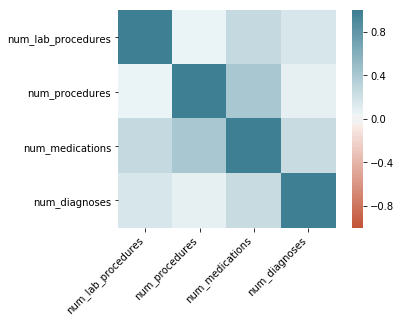

In [17]:
#************************ PLOT 1: Corr Plot ************************#

py_preprocessing.class_module_preprocessing.fn_Plot_Corrplot(df_train_master.drop(['admission_type_id', 'discharge_disposition_id', 'admission_source_id'], axis = 1))

### OBSERVATIONS:
# None of the numerical columns are co-related.

<center><b><span style='color:purple'>PLOT 2: readmitted</span></center>

Below is the categorical distribution: 
NO              0.862655
Within30days    0.137345
Name: readmitted, dtype: float64 


Below is the Bar Plot for readmitted:


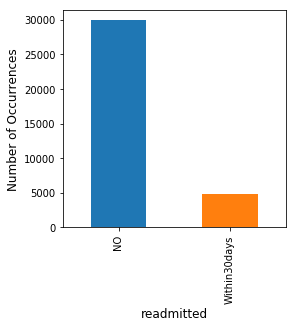

In [18]:
#************************ PLOT 2: Readmitted ************************#

py_preprocessing.class_module_preprocessing.fn_Plot_Bars(df_train, 2, 'readmitted', 4, 4)

### OBSERVATIONS:
# Target variable is a categorical column and is imbalanced. 

<center><b><span style='color:purple'>PLOT 3: gender</span></center>

Below is the categorical distribution: 
Female    0.525887
Male      0.474113
Name: gender, dtype: float64 


Below is the Bar Plot for gender:


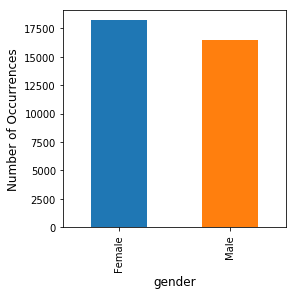

In [19]:
#************************ PLOT 3: Gender ************************#

py_preprocessing.class_module_preprocessing.fn_Plot_Bars(df_train, 3, 'gender', 4, 4)

### OBSERVATIONS:
# Almost equal distribution of males and females

<center><b><span style='color:purple'>PLOT 4: max_glu_serum</span></center>

Below is the categorical distribution: 
None    0.954084
Norm    0.023838
>200    0.012958
>300    0.009120
Name: max_glu_serum, dtype: float64 


Below is the Bar Plot for max_glu_serum:


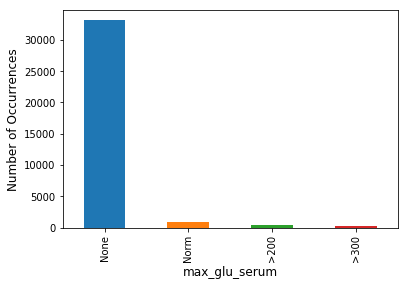

In [20]:
#************************ PLOT 4: Max Glu Serum ************************#

py_preprocessing.class_module_preprocessing.fn_Plot_Bars(df_train_master, 4, 'max_glu_serum',6 , 4)

### OBSERVATIONS:
# Unequal distribution of the different levels
# Can bin Norm, >200 and >300 as Others

<center><b><span style='color:purple'>PLOT 5: A1Cresult</span></center>

Below is the categorical distribution: 
None    0.815065
>8      0.087792
Norm    0.056219
>7      0.040924
Name: A1Cresult, dtype: float64 


Below is the Bar Plot for A1Cresult:


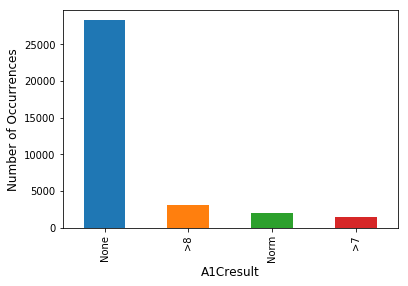

In [21]:
#************************ PLOT 5: A1C Result ************************#

py_preprocessing.class_module_preprocessing.fn_Plot_Bars(df_train_master, 5, 'A1Cresult',6 , 4)

### OBSERVATIONS:
# Unequal distribution of the different levels
# Can bin Norm, >8 and >7 as Others

<center><b><span style='color:purple'>PLOT 6: change</span></center>

Below is the categorical distribution: 
No    0.563665
Ch    0.436335
Name: change, dtype: float64 


Below is the Bar Plot for change:


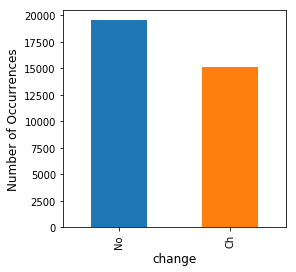

In [22]:
#************************ PLOT 6: Change ************************#

py_preprocessing.class_module_preprocessing.fn_Plot_Bars(df_train_master, 6, 'change',4 , 4)

### OBSERVATIONS:
# Almost equal distribution of the different levels

<center><b><span style='color:purple'>PLOT 7: admission_type_id</span></center>

Below is the categorical distribution: 
1    0.507446
3    0.205253
2    0.182799
6    0.055613
5    0.043665
8    0.004618
7    0.000462
4    0.000144
Name: admission_type_id, dtype: float64 


Below is the Bar Plot for admission_type_id:


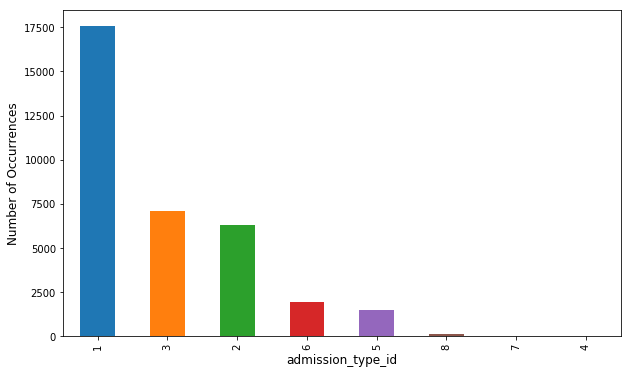

In [23]:
#************************ PLOT 7: Admission Type ID ************************#

py_preprocessing.class_module_preprocessing.fn_Plot_Bars(df_train_master, 7, 'admission_type_id', 10, 6)

### OBSERVATIONS:
# Unequal distribution of the different levels.
# Can bin the levels based on the domain knowledge.

<center><b><span style='color:purple'>PLOT 8: discharge_disposition_id</span></center>

Below is the categorical distribution: 
1     0.614343
3     0.123001
6     0.104877
18    0.038066
22    0.022078
11    0.022020
2     0.021818
5     0.013276
25    0.010216
4     0.007821
7     0.005599
13    0.004877
14    0.004040
23    0.003781
28    0.001616
8     0.000924
15    0.000664
24    0.000375
9     0.000115
19    0.000115
27    0.000087
17    0.000087
12    0.000058
10    0.000058
16    0.000058
20    0.000029
Name: discharge_disposition_id, dtype: float64 


Below is the Bar Plot for discharge_disposition_id:


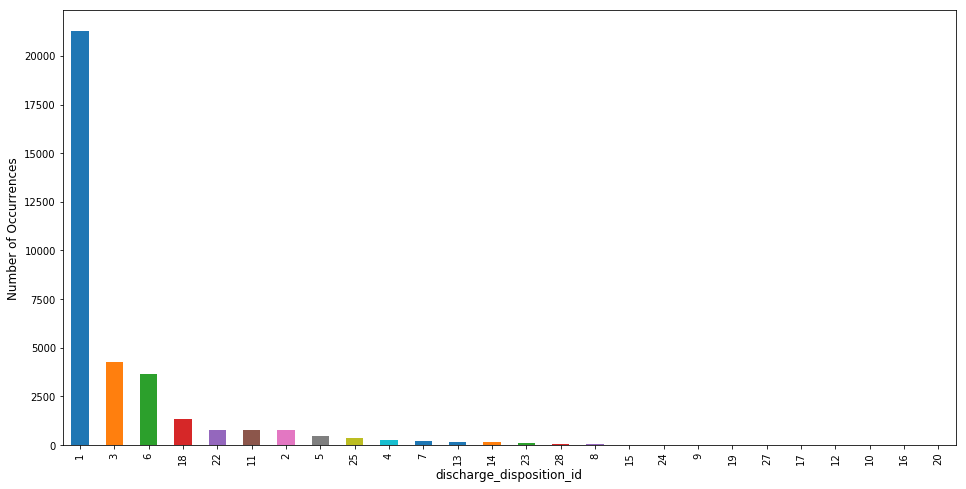

In [24]:
#************************ PLOT 8: Discharge Disposition ID ************************#

py_preprocessing.class_module_preprocessing.fn_Plot_Bars(df_train_master, 8, 'discharge_disposition_id', 16, 8)

### OBSERVATIONS:
# 28 different levels in train data. As per Mapping document provided, this column could have 30 different levels.
# Unequal distribution of the different levels.
# Can bin the levels based on the domain knowledge. Take into consideration the unknown levels as well (***IMP***).

<center><b><span style='color:purple'>PLOT 9: admission_source_id</span></center>

Below is the categorical distribution: 
7     0.517662
1     0.315556
17    0.064733
4     0.042338
6     0.030794
2     0.014719
5     0.008225
9     0.001991
3     0.001876
20    0.001645
8     0.000173
22    0.000087
10    0.000087
11    0.000029
13    0.000029
14    0.000029
25    0.000029
Name: admission_source_id, dtype: float64 


Below is the Bar Plot for admission_source_id:


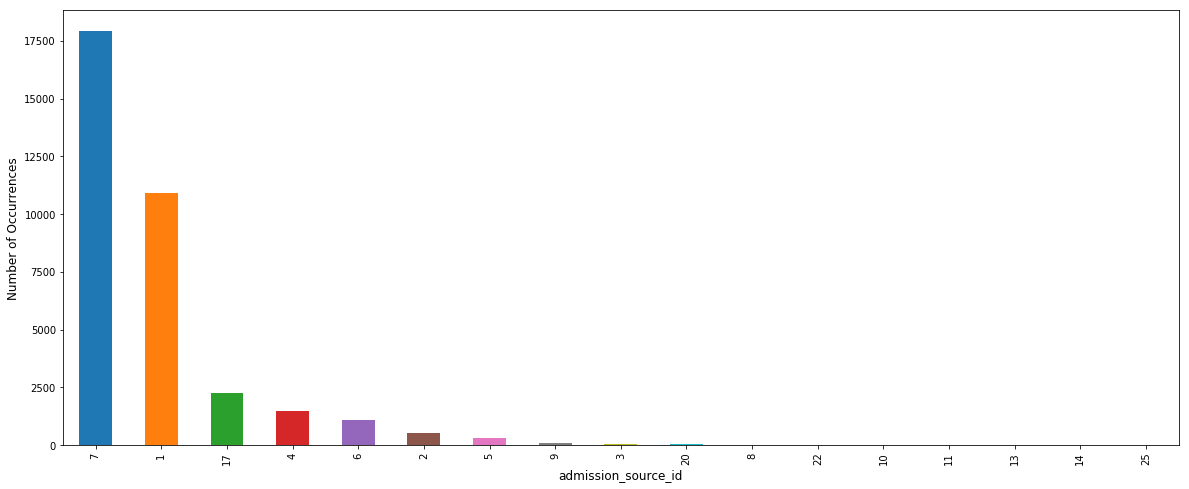

In [25]:
#************************ PLOT 9: Admission Source ID ************************#

py_preprocessing.class_module_preprocessing.fn_Plot_Bars(df_train_master, 9, 'admission_source_id', 20, 8)

### OBSERVATIONS:
# 25 different levels in train data. As per Mapping document provided, this column could have 26 different levels.
# Unequal distribution of the different levels.
# Can bin the levels based on the domain knowledge. Take into consideration the unknown levels as well (***IMP***).

<center><b><span style='color:purple'>PLOT 10: age</span></center>

Below is the categorical distribution: 
[70-80)     0.246234
[60-70)     0.221558
[50-60)     0.175988
[80-90)     0.158326
[40-50)     0.098384
[30-40)     0.042367
[90-100)    0.029293
[20-30)     0.017258
[10-20)     0.007994
[0-10)      0.002597
Name: age, dtype: float64 


Below is the Bar Plot for age:


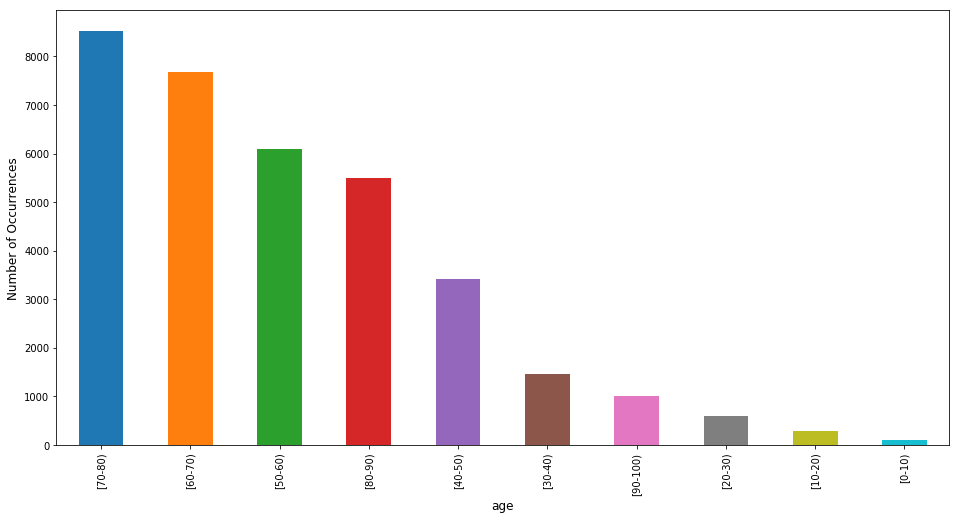

In [26]:
#************************ PLOT 10: Age ************************#

py_preprocessing.class_module_preprocessing.fn_Plot_Bars(df_train_master, 10, 'age', 16, 8)

### OBSERVATIONS:
# Here, age is a categorical column and is expressed as a range of 10 years. 
# Since it can be expressed as a numeric column, we can take the mean of each range.

<center><b><span style='color:purple'>PLOT 11: race</span></center>

Below is the categorical distribution: 
Caucasian          0.737720
AfricanAmerican    0.182799
Hispanic           0.022684
Other              0.017835
Asian              0.007821
Name: race, dtype: float64 


Below is the Bar Plot for race:


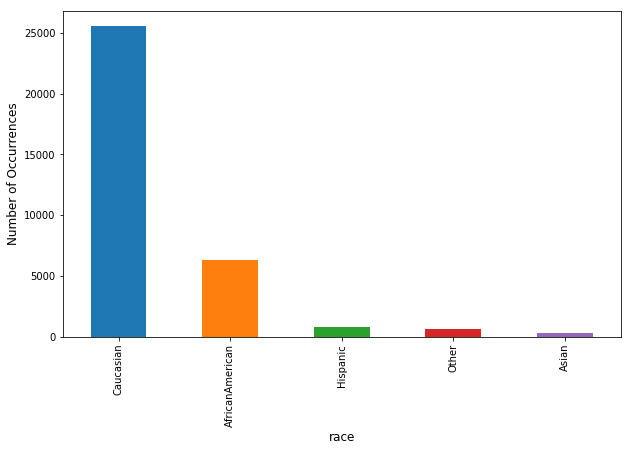

In [27]:
#************************ PLOT 11: Race ************************#

py_preprocessing.class_module_preprocessing.fn_Plot_Bars(df_train_master, 11, 'race', 10, 6)

### OBSERVATIONS:
# Caucasian and AfricanAmerican seem to be the dominant levels in the feature, race. 
# Hispanic, Other and Asian can be binned into one level as each constitutes less than 3% of data.

<center><b><span style='color:purple'>PLOT 12: Frequency Distribution of num_lab_procedures</span></center>

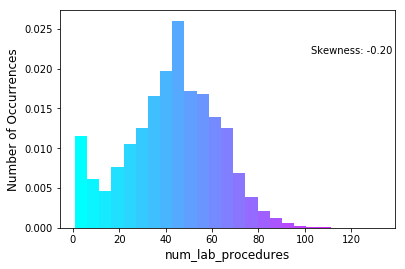

<center><b><span style='color:purple'>PLOT 13: Frequency Distribution of num_procedures</span></center>

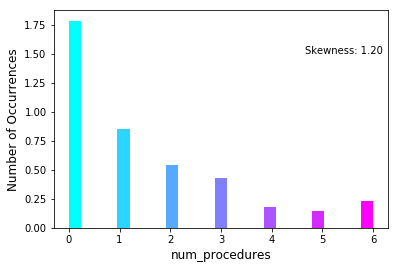

<center><b><span style='color:purple'>PLOT 14: Frequency Distribution of num_medications</span></center>

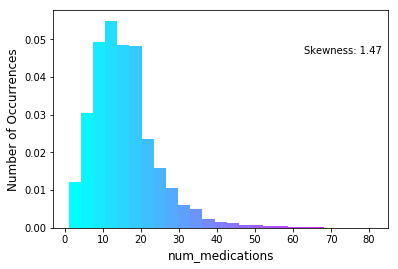

<center><b><span style='color:purple'>PLOT 15: Frequency Distribution of num_diagnoses</span></center>

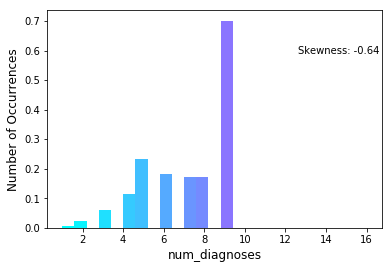

<center><b><span style='color:purple'>PLOT 16: Frequency Distribution of admission_type_id</span></center>

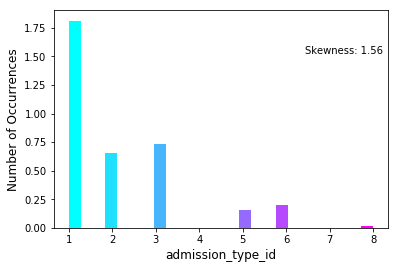

<center><b><span style='color:purple'>PLOT 17: Frequency Distribution of discharge_disposition_id</span></center>

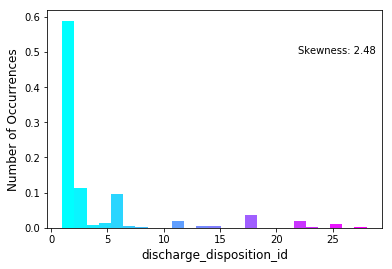

<center><b><span style='color:purple'>PLOT 18: Frequency Distribution of admission_source_id</span></center>

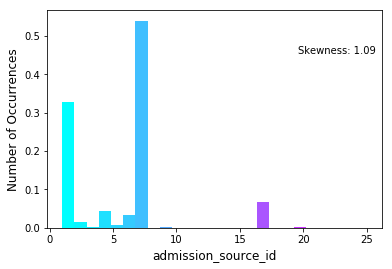

In [28]:
#************************ PLOTS 12 - 15: NUMERICAL COLUMNS ************************#

num_cols = py_preprocessing.class_module_preprocessing.fn_ReturnNumCols(df_train_master)
            
py_preprocessing.class_module_preprocessing.fn_Plot_HistSkewness(df_train_master, num_cols)

### OBSERVATIONS:
# age, num_lab_procedures, num_LP_P have skweness above 2

<center><b><span style='color:purple'>PLOT 16: Readmitted vs Insulin</span></center>

insulin       Down     No  Steady    Up
readmitted                             
NO            2904  15036    9233  2718
Within30days   580   2132    1554   493 




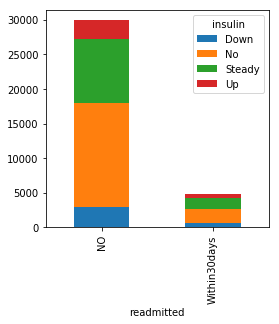

In [29]:
## ************************ PLOT 16: Readmitted vs Insulin ************************#

clarity_color_table = pd.crosstab(index=df_train_master['readmitted'], columns=df_train_master['insulin'])
py_preprocessing.class_module_preprocessing.printmd("PLOT 16: Readmitted vs Insulin")
print(clarity_color_table, "\n\n")

clarity_color_table.plot(kind="bar", 
                 figsize=(4,4),
                 stacked=True)

<p><h1><font face="Arial Header" size="5"><span style="color:purple">PART 5: Data Cleansing</span></font></h1></p>

In [30]:
#************************ Check records containing null for all the 3 diagnosis columns ************************ 

df_train_master[['patientID', 'diagnosis_1', 'diagnosis_2','diagnosis_3']][df_train_master.filter(like='diagnosis_1').isnull().any(1)][df_train_master.filter(like='diagnosis_2').isnull().any(1)][df_train_master.filter(like='diagnosis_3').isnull().any(1)]

,patientID,diagnosis_1,diagnosis_2,diagnosis_3
33682,PT44783,NaN,NaN,NaN


In [31]:
#************************ Delete records containing null for all the 3 diagnosis columns ************************ 

df_train_master = df_train_master[df_train_master.patientID != 'PT44783']
df_train_master.shape[0]

34649

In [32]:
#************************ Null Imputation using Mode of the column ************************#

null_col_list = ['diagnosis_1', 'diagnosis_2', 'diagnosis_3', 'race']
df_train_master = py_preprocessing.class_module_preprocessing.fn_ImputeTrainData_Mode(df_train_master, null_col_list)
df_test_master = py_preprocessing.class_module_preprocessing.fn_ImputeTestData_Mode(df_train_master, df_test_master, null_col_list)

print("Below is the null distribution in train data after imputation: \n")
print(df_train_master[null_col_list].isnull().sum())

Below is the null distribution in train data after imputation: 

diagnosis_1    0
diagnosis_2    0
diagnosis_3    0
race           0
dtype: int64


<p><h1><font face="Arial Header" size="5"><span style="color:purple">PART 6: Feature Engineering</span></font></h1></p>

In [33]:
#************************ FE1: Create a new column, NoOfDaysAdmitted as the number of days stayed in the hospital ************************ 

df_train_master = py_preprocessing.class_module_preprocessing.fn_NoOfDaysAdmitted(df_train_master)
df_test_master = py_preprocessing.class_module_preprocessing.fn_NoOfDaysAdmitted(df_test_master)

df_train_master[['Discharge_date', 'Admission_date', 'NoOfDaysAdmitted']].head(3)

,Discharge_date,Admission_date,NoOfDaysAdmitted
0,2015-07-23,2015-07-18,5
1,2016-04-29,2016-04-23,6
2,2016-05-17,2016-05-13,4


In [34]:
#************************ FE2: Create a new column, drug_prescribed that contains the count of drug prescribed ************************ 

df_train_master = py_preprocessing.class_module_preprocessing.fn_DrugPrescribed(df_train_master)
df_test_master = py_preprocessing.class_module_preprocessing.fn_DrugPrescribed(df_test_master)

py_preprocessing.class_module_preprocessing.printmd("Distribution of drug_prescribed column: \n")
df_train_master['drug_prescribed'].value_counts()

<center><b><span style='color:purple'>Distribution of drug_prescribed column: 
</span></center>

1    15196
0     8820
2     7431
3     2693
4      485
5       23
6        1
Name: drug_prescribed, dtype: int64

In [35]:
#************************ FE3: Convert age categories into numerical as the mid-point values  ************************  

py_preprocessing.class_module_preprocessing.printmd("Distribution of Age column in train data before conversion: \n")
print(df_train_master['age'].value_counts()/df_train_master.shape[0])

df_train_master = py_preprocessing.class_module_preprocessing.fn_BinAge(df_train_master)
df_test_master = py_preprocessing.class_module_preprocessing.fn_BinAge(df_test_master)

py_preprocessing.class_module_preprocessing.printmd("Distribution of Age column in train data after conversion: \n")
print(df_train_master['age'].value_counts()/df_train_master.shape[0])

<center><b><span style='color:purple'>Distribution of Age column in train data before conversion: 
</span></center>

[70-80)     0.246241
[60-70)     0.221536
[50-60)     0.175994
[80-90)     0.158331
[40-50)     0.098387
[30-40)     0.042368
[90-100)    0.029294
[20-30)     0.017259
[10-20)     0.007994
[0-10)      0.002597
Name: age, dtype: float64


<center><b><span style='color:purple'>Distribution of Age column in train data after conversion: 
</span></center>

75    0.246241
65    0.221536
55    0.175994
85    0.158331
45    0.098387
35    0.042368
95    0.029294
25    0.017259
15    0.007994
5     0.002597
Name: age, dtype: float64


In [36]:
#************************ FE4: Bin the column, AdmissionTypeID ************************#

py_preprocessing.class_module_preprocessing.printmd("Bin AdmissionTypeID")

<center><b><span style='color:purple'>Bin AdmissionTypeID</span></center>

<img src="Images/AdmissionTypeID.png" alt="Italian Trulli">


In [37]:
# Bin the AdmissionTypeID based on the above chart
py_preprocessing.class_module_preprocessing.printmd("Distribution of AdmissionTypeID in train data before binning: \n")
print(df_train_master['admission_type_id'].value_counts()/df_train_master.shape[0])

df_train_master = py_preprocessing.class_module_preprocessing.fn_BinAdmissionTypeID(df_train_master)
df_test_master = py_preprocessing.class_module_preprocessing.fn_BinAdmissionTypeID(df_test_master)

py_preprocessing.class_module_preprocessing.printmd("Distribution of AdmissionTypeID in train data after binning: \n")
df_train_master['admission_type_id'].value_counts()/df_train_master.shape[0]

<center><b><span style='color:purple'>Distribution of AdmissionTypeID in train data before binning: 
</span></center>

1    0.507461
3    0.205258
2    0.182776
6    0.055615
5    0.043666
8    0.004618
7    0.000462
4    0.000144
Name: admission_type_id, dtype: float64


<center><b><span style='color:purple'>Distribution of AdmissionTypeID in train data after binning: 
</span></center>

1    0.507461
3    0.205865
2    0.182776
4    0.103899
Name: admission_type_id, dtype: float64

In [38]:
#************************ FE5: Bin the column, AdmissionSourceID ************************#

py_preprocessing.class_module_preprocessing.printmd("Bin AdmissionSourceID")

<center><b><span style='color:purple'>Bin AdmissionSourceID</span></center>

<img src="Images/AdmissionSourceID.png" alt="Italian Trulli">


In [39]:
# Bin the AdmissionSourceID based on the above chart

py_preprocessing.class_module_preprocessing.printmd("Distribution of AdmissionSourceID column before binning: \n")
print(df_train_master['admission_source_id'].value_counts()/df_train_master.shape[0])

df_train_master = py_preprocessing.class_module_preprocessing.fn_BinAdmissionSourceID(df_train_master)
df_test_master = py_preprocessing.class_module_preprocessing.fn_BinAdmissionSourceID(df_test_master)

py_preprocessing.class_module_preprocessing.printmd("Distribution of AdmissionSourceID column after binning: \n")
df_train_master['admission_source_id'].value_counts()/df_train_master.shape[0]

<center><b><span style='color:purple'>Distribution of AdmissionSourceID column before binning: 
</span></center>

7     0.517677
1     0.315565
17    0.064735
4     0.042310
6     0.030795
2     0.014719
5     0.008225
9     0.001991
3     0.001876
20    0.001645
8     0.000173
22    0.000087
10    0.000087
11    0.000029
13    0.000029
14    0.000029
25    0.000029
Name: admission_source_id, dtype: float64


<center><b><span style='color:purple'>Distribution of AdmissionSourceID column after binning: 
</span></center>

3    0.517937
1    0.332160
2    0.081532
4    0.068371
Name: admission_source_id, dtype: float64

In [40]:
#************************ FE6: Bin the column, DischargeDispositionID ************************#

py_preprocessing.class_module_preprocessing.printmd("Bin DischargeDispositionID")

<center><b><span style='color:purple'>Bin DischargeDispositionID</span></center>

<img src="Images/DischargeDispositionID.png" alt="Italian Trulli">


In [41]:
#************************ Bin the column, DischargeDispositionID ************************  

py_preprocessing.class_module_preprocessing.printmd("Distribution of DischargeDispositionID in train data before binning: \n")
print(df_train_master['discharge_disposition_id'].value_counts()/df_train_master.shape[0])

df_train_master = py_preprocessing.class_module_preprocessing.fn_BinDischargeDispositionID(df_train_master)
df_test_master = py_preprocessing.class_module_preprocessing.fn_BinDischargeDispositionID(df_test_master)

py_preprocessing.class_module_preprocessing.printmd("Distribution of DischargeDispositionID in train data after binning: \n")
df_train_master['discharge_disposition_id'].value_counts()/df_train_master.shape[0]

<center><b><span style='color:purple'>Distribution of DischargeDispositionID in train data before binning: 
</span></center>

1     0.614361
3     0.123005
6     0.104880
18    0.038067
22    0.022079
11    0.022021
2     0.021819
5     0.013276
25    0.010217
4     0.007821
7     0.005599
13    0.004849
14    0.004041
23    0.003781
28    0.001616
8     0.000924
15    0.000664
24    0.000375
9     0.000115
19    0.000115
27    0.000087
17    0.000087
12    0.000058
10    0.000058
16    0.000058
20    0.000029
Name: discharge_disposition_id, dtype: float64


<center><b><span style='color:purple'>Distribution of DischargeDispositionID in train data after binning: 
</span></center>

1    0.720165
2    0.194667
5    0.048284
4    0.022165
3    0.014719
Name: discharge_disposition_id, dtype: float64

In [42]:
#************************ FE7-9: Bin the Diagnosis columns ************************#

py_preprocessing.class_module_preprocessing.printmd("Bin the Diagnosis columns")

<center><b><span style='color:purple'>Bin the Diagnosis columns</span></center>

<img src="Images/ICD9_Codes.JPG">

In [43]:
#************************ FE 10: Bin the diagnosis_1 column ************************ 
              
df_train_master = py_preprocessing.class_module_preprocessing.fn_BinDiagnosis(df_train_master, 'diagnosis_1', 17)
df_test_master = py_preprocessing.class_module_preprocessing.fn_BinDiagnosis(df_test_master, 'diagnosis_1', 17)

print("Below is the categorical distribution after binning: ")
print(df_train_master['diagnosis_1'].value_counts()/df_train_master.shape[0], "\n")
py_preprocessing.class_module_preprocessing.fn_ListUniqueLevelsInCatCols(df_train_master, ['diagnosis_1'])

Below is the categorical distribution after binning: 
-7     0.299143
-3     0.104909
-9     0.089959
-8     0.088257
-16    0.075125
-17    0.071171
-13    0.060290
-10    0.050016
-2     0.043032
-1     0.025859
-12    0.025022
-5     0.022713
-6     0.012785
-99    0.012699
-11    0.010188
-4     0.008225
-14    0.000606
Name: diagnosis_1, dtype: float64 

Number of unique levels in diagnosis_1: 17


In [44]:
#************************ FE 11: Re-bin the diagnosis_1 column by grouping the levels less than 3% ************************ 

df_train_master.loc[((df_train_master['diagnosis_1'].astype('int') == -14) | (df_train_master['diagnosis_1'].astype('int') == -4) | (df_train_master['diagnosis_1'].astype('int') == -11) | (df_train_master['diagnosis_1'].astype('int') == -99) | (df_train_master['diagnosis_1'].astype('int') == -6)| (df_train_master['diagnosis_1'].astype('int') == -5) | (df_train_master['diagnosis_1'].astype('int') == -12) | (df_train_master['diagnosis_1'].astype('int') == -1)), 'diagnosis_1'] = '-100'
df_test_master.loc[((df_test_master['diagnosis_1'].astype('int') == -14) | (df_test_master['diagnosis_1'].astype('int') == -4) | (df_test_master['diagnosis_1'].astype('int') == -11) | (df_test_master['diagnosis_1'].astype('int') == -99) | (df_test_master['diagnosis_1'].astype('int') == -6) | (df_test_master['diagnosis_1'].astype('int') == -5) | (df_test_master['diagnosis_1'].astype('int') == -12) | (df_test_master['diagnosis_1'].astype('int') == -1)), 'diagnosis_1'] = '-100'

print("Below is the categorical distribution after re-binning: ")
print(df_train_master['diagnosis_1'].value_counts()/df_train_master.shape[0], "\n")
py_preprocessing.class_module_preprocessing.fn_ListUniqueLevelsInCatCols(df_train_master, ['diagnosis_1'])

Below is the categorical distribution after re-binning: 
-7      0.299143
-100    0.118099
-3      0.104909
-9      0.089959
-8      0.088257
-16     0.075125
-17     0.071171
-13     0.060290
-10     0.050016
-2      0.043032
Name: diagnosis_1, dtype: float64 

Number of unique levels in diagnosis_1: 10


In [45]:
#************************ FE 12: Bin the diagnosis_2 column ************************ 

df_train_master = py_preprocessing.class_module_preprocessing.fn_BinDiagnosis(df_train_master, 'diagnosis_2', 18)
df_test_master = py_preprocessing.class_module_preprocessing.fn_BinDiagnosis(df_test_master, 'diagnosis_2', 18)

print("Below is the categorical distribution after binning: ")
print(df_train_master['diagnosis_2'].value_counts()/df_train_master.shape[0], "\n")
py_preprocessing.class_module_preprocessing.fn_ListUniqueLevelsInCatCols(df_train_master, ['diagnosis_2'])

Below is the categorical distribution after binning: 
-7     0.300153
-3     0.225057
-8     0.092412
-10    0.071373
-16    0.046726
-9     0.039972
-4     0.029294
-12    0.029265
-17    0.027851
-5     0.027331
-99    0.026292
-2     0.025830
-13    0.018673
-1     0.018153
-6     0.013391
-11    0.006753
-14    0.001472
Name: diagnosis_2, dtype: float64 

Number of unique levels in diagnosis_2: 17


In [46]:
#************************ FE 13: Re-bin the diagnosis_2 column by grouping the levels less than 3% ************************ 

df_train_master.loc[((df_train_master['diagnosis_2'].astype('int') == -14) | (df_train_master['diagnosis_2'].astype('int') == -11) | (df_train_master['diagnosis_2'].astype('int') == -6) | (df_train_master['diagnosis_2'].astype('int') == -1) | (df_train_master['diagnosis_2'].astype('int') == -13) | (df_train_master['diagnosis_2'].astype('int') == -2) | (df_train_master['diagnosis_2'].astype('int') == -99) | (df_train_master['diagnosis_2'].astype('int') == -5) | (df_train_master['diagnosis_2'].astype('int') == -17) | (df_train_master['diagnosis_2'].astype('int') == -12) | (df_train_master['diagnosis_2'].astype('int') == -4)), 'diagnosis_2'] = '-100'
df_test_master.loc[((df_test_master['diagnosis_2'].astype('int') == -14) | (df_test_master['diagnosis_2'].astype('int') == -11) | (df_test_master['diagnosis_2'].astype('int') == -6) | (df_test_master['diagnosis_2'].astype('int') == -1) | (df_test_master['diagnosis_2'].astype('int') == -13) | (df_test_master['diagnosis_2'].astype('int') == -2) | (df_test_master['diagnosis_2'].astype('int') == -99) | (df_test_master['diagnosis_2'].astype('int') == -5) | (df_test_master['diagnosis_2'].astype('int') == -17) | (df_test_master['diagnosis_2'].astype('int') == -12) | (df_test_master['diagnosis_2'].astype('int') == -4)), 'diagnosis_2'] = '-100'

print("Below is the categorical distribution after re-binning: ")
print(df_train_master['diagnosis_2'].value_counts()/df_train_master.shape[0], "\n")
py_preprocessing.class_module_preprocessing.fn_ListUniqueLevelsInCatCols(df_train_master, ['diagnosis_2'])

Below is the categorical distribution after re-binning: 
-7      0.300153
-3      0.225057
-100    0.224307
-8      0.092412
-10     0.071373
-16     0.046726
-9      0.039972
Name: diagnosis_2, dtype: float64 

Number of unique levels in diagnosis_2: 7


In [47]:
#************************ FE 14: Bin the diagnosis_3 columns ************4************ 

df_train_master = py_preprocessing.class_module_preprocessing.fn_BinDiagnosis(df_train_master, 'diagnosis_3', 20)
df_test_master = py_preprocessing.class_module_preprocessing.fn_BinDiagnosis(df_test_master, 'diagnosis_3', 20)

print("Below is the categorical distribution after binning: ")
print(df_train_master['diagnosis_3'].value_counts()/df_train_master.shape[0], "\n")
py_preprocessing.class_module_preprocessing.fn_ListUniqueLevelsInCatCols(df_train_master, ['diagnosis_3'])

Below is the categorical distribution after binning: 
-3     0.293602
-7     0.285953
-8     0.061098
-10    0.054114
-99    0.049698
-16    0.044475
-9     0.033709
-5     0.029842
-4     0.024503
-17    0.022367
-13    0.019539
-12    0.019250
-2     0.019077
-1     0.018413
-6     0.018240
-11    0.004877
-14    0.001241
Name: diagnosis_3, dtype: float64 

Number of unique levels in diagnosis_3: 17


In [48]:
#************************ FE 15: Re-bin the diagnosis_3 column by grouping the levels less than 4% ************************ 

df_train_master.loc[((df_train_master['diagnosis_3'].astype('int') == -14) | (df_train_master['diagnosis_3'].astype('int') == -11) | (df_train_master['diagnosis_3'].astype('int') == -6) | (df_train_master['diagnosis_3'].astype('int') == -1) | (df_train_master['diagnosis_3'].astype('int') == -2) | (df_train_master['diagnosis_3'].astype('int') == -12) | (df_train_master['diagnosis_3'].astype('int') == -13) | (df_train_master['diagnosis_3'].astype('int') == -17) | (df_train_master['diagnosis_3'].astype('int') == -4) | (df_train_master['diagnosis_3'].astype('int') == -5) | (df_train_master['diagnosis_3'].astype('int') == -9)), 'diagnosis_3'] = '-100'
df_test_master.loc[((df_test_master['diagnosis_3'].astype('int') == -14) | (df_test_master['diagnosis_3'].astype('int') == -11) | (df_test_master['diagnosis_3'].astype('int') == -6) | (df_test_master['diagnosis_3'].astype('int') == -1) | (df_test_master['diagnosis_3'].astype('int') == -2) | (df_test_master['diagnosis_3'].astype('int') == -12) | (df_test_master['diagnosis_3'].astype('int') == -13) | (df_test_master['diagnosis_3'].astype('int') == -17) | (df_test_master['diagnosis_3'].astype('int') == -4) | (df_test_master['diagnosis_3'].astype('int') == -5) | (df_test_master['diagnosis_3'].astype('int') == -9)), 'diagnosis_3'] = '-100'

print("Below is the categorical distribution after re-binning: ")
print(df_train_master['diagnosis_3'].value_counts()/df_train_master.shape[0], "\n")
py_preprocessing.class_module_preprocessing.fn_ListUniqueLevelsInCatCols(df_train_master, ['diagnosis_3'])

Below is the categorical distribution after re-binning: 
-3      0.293602
-7      0.285953
-100    0.211059
-8      0.061098
-10     0.054114
-99     0.049698
-16     0.044475
Name: diagnosis_3, dtype: float64 

Number of unique levels in diagnosis_3: 7


In [49]:
#************************ FE 16: Creating 6 numerical columns ************************  

df_train_master = py_preprocessing.class_module_preprocessing.fn_CreateNumCols(df_train_master)
df_test_master = py_preprocessing.class_module_preprocessing.fn_CreateNumCols(df_test_master)

df_train_master[['num_medications', 'num_lab_procedures','num_diagnoses', 'num_procedures','num_LP_P', 'num_LP_M', 'num_P_M', 'num_P_D', 'num_D_M']].head()

,num_medications,num_lab_procedures,num_diagnoses,num_procedures,num_LP_P,num_LP_M,num_P_M,num_P_D,num_D_M
0,7,18,7,1,19,25,8,8,14
1,16,40,9,4,44,56,20,13,25
2,12,39,5,1,40,51,13,6,17
3,10,1,9,0,1,11,10,9,19
4,16,44,9,0,44,60,16,9,25


In [50]:
#************************ FE 17: Convert to categorical columns and dummification ************************#  

train_cat_cols = ['race', 'gender','diagnosis_1', 'diagnosis_2', 'diagnosis_3', 'max_glu_serum', 'A1Cresult', 'change', 
              'diabetesMed', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'readmitted',
           'metformin', 'repaglinide', 'glimepiride', 'glipizide', 'glyburide',
            'pioglitazone', 'rosiglitazone', 'insulin']

test_cat_cols = ['race', 'gender','diagnosis_1', 'diagnosis_2', 'diagnosis_3', 'max_glu_serum', 'A1Cresult', 'change', 
              'diabetesMed', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 
            'metformin', 'repaglinide', 'glimepiride', 'glipizide', 'glyburide',
            'pioglitazone', 'rosiglitazone', 'insulin']

# Convert to categorical columns
df_train_master = py_preprocessing.class_module_preprocessing.fn_ConvertToCatCols(df_train_master, train_cat_cols)
df_test_master = py_preprocessing.class_module_preprocessing.fn_ConvertToCatCols(df_test_master, test_cat_cols)


# Dummification
df_train_master = py_preprocessing.class_module_preprocessing.fn_Dummify(df_train_master, train_cat_cols)
df_test_master = py_preprocessing.class_module_preprocessing.fn_Dummify(df_test_master, test_cat_cols)

In [52]:
#************************ FE 18: Drop the unwanted columns ************************#

print("Number of columns before dropping the columns: ", df_train_master.shape)

invalid_drug_cols = (list(set(all_drug_cols) - set(valid_drug_cols))) 
drop_col_list = ['patientID', 'AdmissionID', 'Admission_date', 'Discharge_date', 'weight', 'payer_code', 'medical_specialty']
drop_col_list.extend(invalid_drug_cols)

df_train_master = py_preprocessing.class_module_preprocessing.fn_DropCols(df_train_master, drop_col_list)
df_test_master = py_preprocessing.class_module_preprocessing.fn_DropCols(df_test_master, drop_col_list)

print("\n\nNumber of columns after dropping the columns: ", df_train_master.shape)

Number of columns before dropping the columns:  (34649, 101)

Dropping the columns: ['patientID', 'AdmissionID', 'Admission_date', 'Discharge_date', 'weight', 'payer_code', 'medical_specialty', 'nateglinide', 'miglitol', 'acarbose', 'troglitazone', 'tolazamide', 'glipizide.metformin', 'tolbutamide', 'acetohexamide', 'metformin.pioglitazone', 'chlorpropamide', 'metformin.rosiglitazone', 'glyburide.metformin']

Dropping the columns: ['patientID', 'AdmissionID', 'Admission_date', 'Discharge_date', 'weight', 'payer_code', 'medical_specialty', 'nateglinide', 'miglitol', 'acarbose', 'troglitazone', 'tolazamide', 'glipizide.metformin', 'tolbutamide', 'acetohexamide', 'metformin.pioglitazone', 'chlorpropamide', 'metformin.rosiglitazone', 'glyburide.metformin']


Number of columns after dropping the columns:  (34649, 82)


In [53]:
#************************ FE 19A: Identifying the skewed features ************************  

num_cols = py_preprocessing.class_module_preprocessing.fn_ReturnNumCols(df_train_master)

skewed_feats = (df_train_master[num_cols]).apply(lambda x: skew(x.dropna()))
py_preprocessing.class_module_preprocessing.printmd('Skewness of all numerical features')
print(skewed_feats)

skewed_feats_gt1 = skewed_feats[skewed_feats > 1]
py_preprocessing.class_module_preprocessing.printmd('\nFeatures with skewness > 1')
print(skewed_feats_gt1)

<center><b><span style='color:purple'>Skewness of all numerical features</span></center>

age                  -0.616383
num_lab_procedures   -0.196543
num_procedures        1.201934
num_medications       1.467078
num_diagnoses        -0.636887
NoOfDaysAdmitted      1.186482
drug_prescribed       0.680933
num_LP_P             -0.166583
num_LP_M              0.113448
num_LP_D             -0.163623
num_P_M               1.465262
num_P_D               0.059848
num_D_M               1.161575
dtype: float64


<center><b><span style='color:purple'>
Features with skewness > 1</span></center>

num_procedures      1.201934
num_medications     1.467078
NoOfDaysAdmitted    1.186482
num_P_M             1.465262
num_D_M             1.161575
dtype: float64


In [54]:
#************************ FE 19B: Identifying the best transformation for the skewed features ************************#

py_preprocessing.class_module_preprocessing.printmd('Identifying the best transformation for the skewed features')
for col in skewed_feats_gt1.index:
      py_preprocessing.class_module_preprocessing.fn_MathTransform(df_train_master, col)

<center><b><span style='color:purple'>Identifying the best transformation for the skewed features</span></center>

Feature:  num_procedures
Skewness of log1p:  0.4185551984645461
Skewness of sqrt:  0.30743002981334144
Skewness of boxcox:  0.1587417034203136


Feature:  num_medications
Skewness of log1p:  -0.4033923586991401
Skewness of sqrt:  0.44421798162503484
Skewness of boxcox:  0.014095984355825644


Feature:  NoOfDaysAdmitted
Skewness of log1p:  0.15030820315357218
Skewness of sqrt:  0.515191006660542
Skewness of boxcox:  0.019983061130799937


Feature:  num_P_M
Skewness of log1p:  -0.39547133192402595
Skewness of sqrt:  0.4548717084165484
Skewness of boxcox:  0.012510088481366134


Feature:  num_D_M
Skewness of log1p:  -0.3205117292248549
Skewness of sqrt:  0.36804868602680546
Skewness of boxcox:  0.013624487521473412




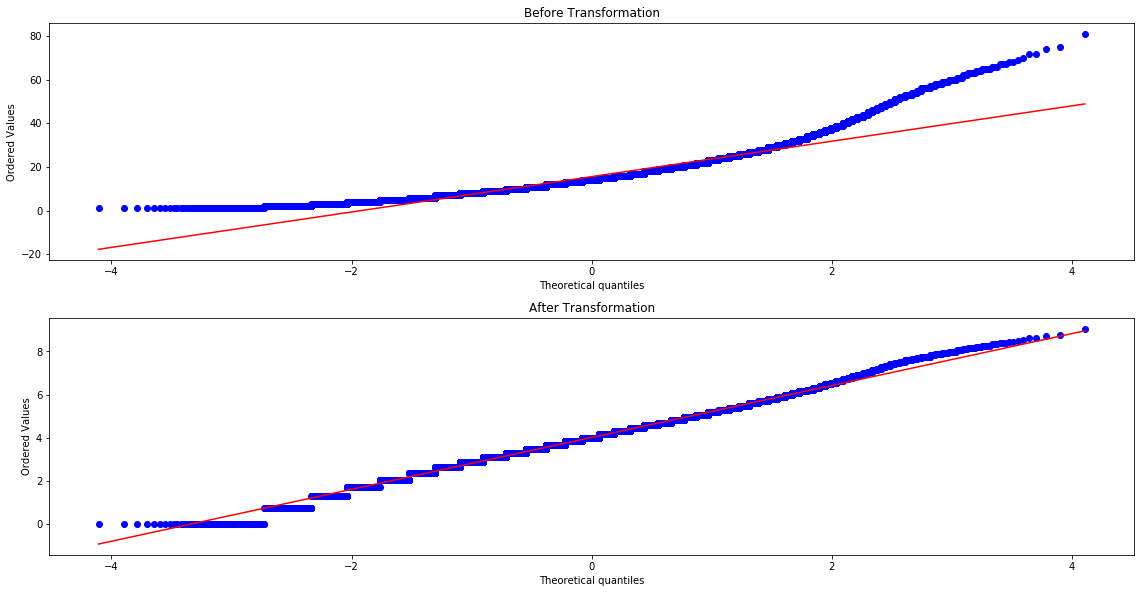

In [55]:
#************************ FE 19C: Explore the before and after transformation plots ************************#

fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(311)
prob = stats.probplot(df_train_master['num_medications'], dist=stats.norm, plot=ax1)
ax1.set_title('Before Transformation')

ax2 = fig.add_subplot(312)
xt, _ = stats.boxcox(df_train_master['num_medications'])
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('After Transformation')

plt.tight_layout()

In [56]:
#************************ FE 19D: Perform boxcox transformation ************************#

tmp_train = df_train_master[num_cols]
tmp_test = df_test_master[num_cols]

for col in tmp_train:
    tmp_train[col] = boxcox(tmp_train[col]+1)[0]
    tmp_test[col] = boxcox(tmp_test[col]+1)[0]

In [57]:
#************************ FE 20: Standardization of Numerical columns ************************#

scaler = StandardScaler()
df_train_master[num_cols] = scaler.fit_transform(tmp_train)
df_test_master[num_cols] = scaler.transform(tmp_test)

In [58]:
# Check the first 2 records in train data after all the feature engineering
df_train_master[num_cols].head(2)

,age,num_lab_procedures,num_procedures,num_medications,num_diagnoses,NoOfDaysAdmitted,drug_prescribed,num_LP_P,num_LP_M,num_LP_D,num_P_M,num_P_D,num_D_M
0,1.311909,-1.237465,0.195654,-1.161924,-0.193782,0.557038,0.940232,-1.250979,-1.430125,-1.218768,-1.085530,-0.192326,-0.991051
1,0.569826,-0.127198,1.339353,0.243104,0.968108,0.832126,-0.002612,-0.001776,-0.068593,-0.046042,0.503774,1.561148,0.391387


In [59]:
# Check the first 2 records in test data after all the feature engineering
df_test_master[num_cols].head(2)

,age,num_lab_procedures,num_procedures,num_medications,num_diagnoses,NoOfDaysAdmitted,drug_prescribed,num_LP_P,num_LP_M,num_LP_D,num_P_M,num_P_D,num_D_M
0,-0.311151,0.315070,-1.061619,-0.741188,1.554384,0.198732,-1.427318,0.248683,-0.020548,0.377927,-0.864410,0.206008,-0.130910
1,-0.866460,-0.033466,1.143924,1.463203,0.135425,0.198732,1.642058,0.049678,0.468956,-0.063306,1.515287,0.565957,1.770588


<p><h1><font face="Arial Header" size="5"><span style="color:purple">PART 7: Model Building</span></font></h1></p>

In [374]:
#************************ Split into train and validation data ************************#

X = df_train_master.drop(['readmitted_Within30days'], axis=1) 
y = df_train_master['readmitted_Within30days'].astype('category')

# Use stratified sampling for train-test split for imbalanced data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0, stratify = df_train_master['readmitted_Within30days'])
print('y shape: \n', (df_train_master.readmitted_Within30days.value_counts()))
print('\ny_train shape {}'.format(Counter(y_train)))
print('y_test shape {}'.format(Counter(y_test)))

y shape: 
 0    29890
1     4759
Name: readmitted_Within30days, dtype: int64

y_train shape Counter({0: 22417, 1: 3569})
y_test shape Counter({0: 7473, 1: 1190})


In [375]:
#************************ Use Smoting for imbalanced data ************************#

print('Original dataset shape {}'.format(Counter(y_train)))
sm = SMOTE(random_state=20)
train_input_new, train_output_new = sm.fit_sample(X_train, y_train)
print('New dataset shape {}'.format(Counter(train_output_new)))

train_input_new = pd.DataFrame(train_input_new, columns = list(X.columns))
X_train, X_test, y_train, y_test = train_test_split(train_input_new, train_output_new, test_size=0.20, random_state=0)

Original dataset shape Counter({0: 22417, 1: 3569})
New dataset shape Counter({1: 22417, 0: 22417})


<p><h1><font face="Arial Header" size="3"><span style="color:purple">PART 7.1.1: Model Building using Decision Tree and Smoting</span></font></h1></p>

Text(0,0.5,'Recall/Accuracy')

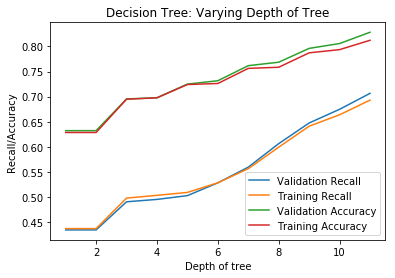

In [77]:
# Setup arrays to store train and test accuracies
dep = np.arange(1, 12)
train_recall = np.empty(len(dep))
test_recall = np.empty(len(dep))
train_accuracy = np.empty(len(dep))
test_accuracy = np.empty(len(dep))

# Loop over different values of k
for i, k in enumerate(dep):
    # Setup a Decision Tree Classifier 
    clf_dt = DecisionTreeClassifier(max_depth=k, criterion = "entropy", random_state=9)
    
    # Fit the classifier to the train data and predict on train/validation data
    clf_dt.fit(X_train, y_train)
    y_pred_train = clf_dt.predict(X_train)
    y_pred = clf_dt.predict(X_test)

    # Compute accuracy/recall on the training set
    train_accuracy[i] = clf_dt.score(X_train, y_train)
    train_recall[i] = metrics.recall_score(y_train, y_pred_train)

    # Compute accuracy/recall on the validation set
    test_accuracy[i] = clf_dt.score(X_test, y_test)
    test_recall[i] = metrics.recall_score(y_test, y_pred)

# Generate plot
plt.title('Decision Tree: Varying Depth of Tree')
plt.plot(dep, train_recall, label = 'Validation Recall')
plt.plot(dep, test_recall, label = 'Training Recall')
plt.legend()
plt.xlabel('Depth of tree')
plt.ylabel('Recall')

plt.title('Decision Tree: Varying Depth of Tree')
plt.plot(dep, train_accuracy, label = 'Validation Accuracy')
plt.plot(dep, test_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Depth of tree')
plt.ylabel('Recall/Accuracy')

### OBSERVATIONS:
# 1) When the depth of the tree is less, training accuracy is almost equal to the test accuracy. 
# 2) As the tree depth increases, the training accuracy increases, however, the testing accuracy stays stagnant. This is 
#    overfitting.
# 3) From the graph, tree_Depth = 11 can be considered as optimum value.

In [68]:
# Use the max_depth as 11 and calculate the stats
clf_dt = DecisionTreeClassifier(max_depth=11, criterion = "entropy", random_state=9)

# Fit the classifier to the train data and predict on train/validation data
%time clf_dt.fit(X_train, y_train)
y_pred_train = clf_dt.predict(X_train)
y_pred = clf_dt.predict(X_test)

# Compute the stats
py_preprocessing.class_module_preprocessing.fn_PrintStats(y_train, y_pred_train, y_test, y_pred)

Wall time: 664 ms

Metrics on Train Data:::::::
Confusion Matrix:
 [[17066   906]
 [ 5251 12644]]
Accuracy: 0.8283380265982658
Precision: 0.9331365313653136
Recall: 0.7065660799105895
Classification Report:
               precision    recall  f1-score   support

           0     0.7647    0.9496    0.8472     17972
           1     0.9331    0.7066    0.8042     17895

    accuracy                         0.8283     35867
   macro avg     0.8489    0.8281    0.8257     35867
weighted avg     0.8487    0.8283    0.8257     35867



Metrics on Validation Data:::::::
Confusion Matrix:
 [[4150  295]
 [1388 3134]]
Accuracy: 0.8123118099698896
Precision: 0.9139690871974336
Recall: 0.6930561698363555
Classification Report:
               precision    recall  f1-score   support

           0     0.7494    0.9336    0.8314      4445
           1     0.9140    0.6931    0.7883      4522

    accuracy                         0.8123      8967
   macro avg     0.8317    0.8133    0.8099      8967
w

<p><h1><font face="Arial Header" size="3"><span style="color:purple">PART 7.1.2: Model Building using Adaboost and Smoting</span></font></h1></p>

In [90]:
# Define the param grid
param_grid = { 'n_estimators' : [100,200, 500], 'learning_rate' : [0.1, 0.5,0.9]}

# Create the model
clf = GridSearchCV(AdaBoostClassifier(
            DecisionTreeClassifier(max_depth=9)), param_grid, scoring = 'recall', n_jobs=-1)

# Fit on train data and get the best model
%time clf.fit(X_train, y_train)
best_ada_model = clf.best_estimator_
print ("Best Score: ",clf.best_score_, clf.best_params_) 
y_pred = best_ada_model.predict(X_test)

# Compute the stats
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n",cnf_matrix)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Classification Report:\n",classification_report(y_test,y_pred,digits=4))

# 'n_estimators' : [100,200],'learning_rate' : [0.5,0.9]
# Accuracy: 0.90598862495818
# Precision: 0.9545342228811465
# Recall: 0.8542680229986731

#  { 'n_estimators' : [100,200, 500], 'learning_rate' : [0.1, 0.5,0.9]}
# Best Score:  0.8599608065851742 {'learning_rate': 0.1, 'n_estimators': 100}
# Accuracy: 0.9089996654399465
# Precision: 0.9543894065718489
# Recall: 0.8606811145510835

Wall time: 33min 29s
Best Score:  0.8599608065851742 {'learning_rate': 0.1, 'n_estimators': 100}
Confusion Matrix:
 [[4259  186]
 [ 630 3892]]
Accuracy: 0.9089996654399465
Precision: 0.9543894065718489
Recall: 0.8606811145510835
Classification Report:
               precision    recall  f1-score   support

           0     0.8711    0.9582    0.9126      4445
           1     0.9544    0.8607    0.9051      4522

    accuracy                         0.9090      8967
   macro avg     0.9128    0.9094    0.9088      8967
weighted avg     0.9131    0.9090    0.9088      8967



<p><h1><font face="Arial Header" size="3"><span style="color:purple">PART 7.1.3: Model Building using Random Forest and Smoting</span></font></h1></p>

In [72]:
# Create basic model
rfc = RandomForestClassifier(n_jobs=-1, max_features='sqrt', criterion = 'entropy') 

# Create the param_grid
param_grid = { 
           "n_estimators" : [300,500],
           "max_depth" : [5, 10]
            }

# Fit on train data and get the best model
clf_RF = GridSearchCV(estimator = rfc, param_grid=param_grid, scoring = 'recall', cv = 5, verbose = 1)
%time clf_RF.fit(X=X_train, y=y_train)
best_RF_model = clf_RF.best_estimator_
print ("Best Score: ",clf_RF.best_score_, clf_RF.best_params_) 

# Predict on train and validation data
y_pred_train = best_RF_model.predict(X_train)
y_pred = best_RF_model.predict(X_test)

# Compute the stats
py_preprocessing.class_module_preprocessing.fn_PrintStats(y_train, y_pred_train, y_test, y_pred)

### Without smoting - Without diagnosis cols
# Accuracy: 0.8613644234099042
# Precision: 0.0
# Recall: 0.0

### Without smoting - Without diagnosis cols
# Accuracy: 0.7992643780650914
# Precision: 0.8383838383838383
# Recall: 0.740906047757197

### With smoting - With diagnosis cols rebinned
# Accuracy: 0.8481943825234062
# Precision: 0.8778773927792586
# Recall: 0.8085248828386521

### With smoting - With diagnosis cols rebinned, with insulin dummified
# Accuracy: 0.8555506018724922
# Precision: 0.895259369570613
# Recall: 0.8049542512831958

### With smoting - With diagnosis cols rebinned, with insulin dummified, with num_interactions
# Accuracy: 0.8604547481052163
# Precision: 0.9021170610211706
# Recall: 0.808301718366436

### With smoting - With diagnosis cols rebinned, with num_interactions, with all drug cols Binned+dummified
# Accuracy: 0.8662505572893446
# Precision: 0.9077802634849614
# Recall: 0.8149966525329168

### With smoting - With diagnosis cols rebinned, with num_interactions, with all drug cols dummified
# Accuracy: 0.8691484618814088
# Precision: 0.9191381495564005
# Recall: 0.8091943762553001

### Stratified Sampling + Smoting + Boxcox Transformation + Normalization
# Accuracy: 0.8874763019962083
# Precision: 0.9203158650394831
# Recall: 0.8505086245024326

### Stratified Sampling + Smoting + Boxcox Transformation + Normalization 
# Best Score:  0.8525844522629563 {'max_depth': 10, 'n_estimators': 300}
# Accuracy: 0.8874763019962083
# Precision: 0.9201148050705573
# Recall: 0.8507297655904467

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.5min finished


Wall time: 3min 41s
Best Score:  0.8525844522629563 {'max_depth': 10, 'n_estimators': 300}

Metrics on Train Data:::::::
Confusion Matrix:
 [[16998   974]
 [ 2371 15524]]
Accuracy: 0.9067387849555302
Precision: 0.9409625409140502
Recall: 0.867504889633976
Classification Report:
               precision    recall  f1-score   support

           0     0.8776    0.9458    0.9104     17972
           1     0.9410    0.8675    0.9027     17895

    accuracy                         0.9067     35867
   macro avg     0.9093    0.9067    0.9066     35867
weighted avg     0.9092    0.9067    0.9066     35867



Metrics on Validation Data:::::::
Confusion Matrix:
 [[4111  334]
 [ 675 3847]]
Accuracy: 0.8874763019962083
Precision: 0.9201148050705573
Recall: 0.8507297655904467
Classification Report:
               precision    recall  f1-score   support

           0     0.8590    0.9249    0.8907      4445
           1     0.9201    0.8507    0.8841      4522

    accuracy                         

<p><h1><font face="Arial Header" size="3"><span style="color:purple">PART 7.1.4: Model Building using XGBoost and Smoting</span></font></h1></p>

In [76]:
# Create a model and fit on the train data 
clf_XGB = XGBClassifier(n_jobs=-1, n_estimators = 500, max_features='sqrt', criterion = 'entropy', gamma = 0.5, 
                        learning_rate = 0.1, scoring = 'recall', max_depth = 10)
%time clf_XGB.fit(X_train, y_train)

# Predict on train and validation data
y_pred_train =clf_XGB.predict(X_train)
y_pred = clf_XGB.predict(X_test)

# Compute the stats
py_preprocessing.class_module_preprocessing.fn_PrintStats(y_train, y_pred_train, y_test, y_pred)


### Without smoting - With diagnosis cols
# Accuracy: 0.8609026895994459
# Precision: 0.16666666666666666
# Recall: 0.0008326394671107411

### Without smoting - Without diagnosis cols
# Accuracy: 0.8613644234099042
# Precision: 0.5
# Recall: 0.0008326394671107411

### With smoting - Without diagnosis cols
# Accuracy: 0.9001337494427106
# Precision: 0.9576206280316569
# Recall: 0.837089935282303

### With smoting - With diagnosis cols rebinned
# Accuracy: 0.8983504235399019
# Precision: 0.9455680399500624
# Recall: 0.8451238562820799

### With smoting - With diagnosis cols rebinned, with insulin dummified
# Accuracy: 0.9001337494427106
# Precision: 0.9489105935386927
# Recall: 0.845570185226512

### With smoting - With diagnosis cols rebinned, with insulin dummified, with num_interactions
# Accuracy: 0.903254569772626
# Precision: 0.9528703935823515
# Recall: 0.8482481588931042

### With smoting - With diagnosis cols rebinned, with num_interactions, with all drug cols binned+dummified
# Accuracy: 0.9096076683013821
# Precision: 0.9697900665642601
# Recall: 0.8453470207542959

### With smoting - With diagnosis cols rebinned, with num_interactions, with valid drug cols dummified
# Accuracy: 0.9099420419081587
# Precision: 0.9702944942381562
# Recall: 0.845570185226512

### Stratified Sampling + Smoting + Boxcox Transformation + Normalization - GridSearchCV - Submision File8
# Accuracy: 0.9176982268317163
# Precision: 0.9893947232281428
# Recall: 0.8458646616541353

Wall time: 1min 39s

Metrics on Train Data:::::::
Confusion Matrix:
 [[17971     1]
 [  846 17049]]
Accuracy: 0.9763849778347785
Precision: 0.9999413489736071
Recall: 0.9527242246437553
Classification Report:
               precision    recall  f1-score   support

           0     0.9550    0.9999    0.9770     17972
           1     0.9999    0.9527    0.9758     17895

    accuracy                         0.9764     35867
   macro avg     0.9775    0.9763    0.9764     35867
weighted avg     0.9774    0.9764    0.9764     35867



Metrics on Validation Data:::::::
Confusion Matrix:
 [[4404   41]
 [ 697 3825]]
Accuracy: 0.9176982268317163
Precision: 0.9893947232281428
Recall: 0.8458646616541353
Classification Report:
               precision    recall  f1-score   support

           0     0.8634    0.9908    0.9227      4445
           1     0.9894    0.8459    0.9120      4522

    accuracy                         0.9177      8967
   macro avg     0.9264    0.9183    0.9174      8967

<p><h1><font face="Arial Header" size="3"><span style="color:purple">PART 7.1.5: Model Building using CatBoost and Smoting</span></font></h1></p>

In [61]:
# Create the categorical feature list
categorical_features_indices = np.where(df_train_master.dtypes != np.float64)[0] 

# Create the CatBoostClassifier
clf_CatB = CatBoostClassifier(iterations=500,  learning_rate=0.1, eval_metric = 'Recall', verbose=False)

# Fit the model on train data
%time clf_CatB.fit(X_train, y_train,cat_features=categorical_features_indices[:-1],eval_set=(X_test, y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Wall time: 8min 10s


In [62]:
# Predict on train and validation data
y_pred_train =clf_CatB.predict(X_train)
y_pred = clf_CatB.predict(X_test)

# Compute the stats
py_preprocessing.class_module_preprocessing.fn_PrintStats(y_train, y_pred_train, y_test, y_pred)

### With smoting - With diagnosis cols rebinned
# Accuracy: 0.9121711992866697
# Precision: 0.9610486891385768
# Recall: 0.8589600535594734

### With smoting - With diagnosis cols rebinned, with insulin dummified
# Accuracy: 0.9150691038787339
# Precision: 0.9636000997257542
# Recall: 0.8625306851149297

### With smoting - With diagnosis cols rebinned, with insulin dummified, with num_interactions
# Accuracy: 0.9236513597860009
# Precision: 0.972139303482587
# Recall: 0.8721267574202187

### With smoting - With diagnosis cols rebinned, with num_interactions, with valid drug cols dummified
# Accuracy: 0.9239433478309357
# Precision: 0.9809619238476954
# Recall: 0.8659885006634233


Metrics on Train Data:::::::
Confusion Matrix:
 [[17665   307]
 [ 1333 16562]]
Accuracy: 0.9542755178855216
Precision: 0.9818009366293201
Recall: 0.9255099189717798
Classification Report:
               precision    recall  f1-score   support

           0     0.9298    0.9829    0.9556     17972
           1     0.9818    0.9255    0.9528     17895

    accuracy                         0.9543     35867
   macro avg     0.9558    0.9542    0.9542     35867
weighted avg     0.9558    0.9543    0.9542     35867



Metrics on Validation Data:::::::
Confusion Matrix:
 [[4369   76]
 [ 606 3916]]
Accuracy: 0.9239433478309357
Precision: 0.9809619238476954
Recall: 0.8659885006634233
Classification Report:
               precision    recall  f1-score   support

           0     0.8782    0.9829    0.9276      4445
           1     0.9810    0.8660    0.9199      4522

    accuracy                         0.9239      8967
   macro avg     0.9296    0.9244    0.9237      8967
weighted avg     0.

<p><h1><font face="Arial Header" size="3"><span style="color:purple">PART 7.2.1: Model Building using Decision Tree and without Smoting</span></font></h1></p>

Text(0,0.5,'Recall')

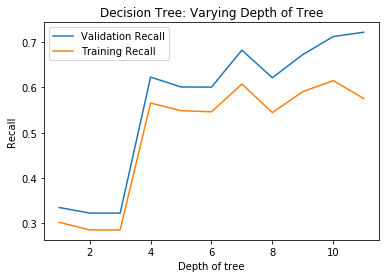

In [55]:
# Setup arrays to store train and test accuracies
dep = np.arange(1, 12)
train_recall = np.empty(len(dep))
test_recall = np.empty(len(dep))
train_accuracy = np.empty(len(dep))
test_accuracy = np.empty(len(dep))

# Loop over different values of k
for i, k in enumerate(dep):
    # Setup a Decision Tree Classifier 
    clf_dt = DecisionTreeClassifier(max_depth=k, criterion = "entropy", random_state=9, class_weight  = 'balanced')
    # The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies 
    # in the input data as ``n_samples / (n_classes * np.bincount(y))
    
    # Fit the classifier to the train data and predict on train/validation data
    clf_dt.fit(X_train, y_train)
    y_pred_train = clf_dt.predict(X_train)
    y_pred = clf_dt.predict(X_test)

    # Compute accuracy/recall on the training set
    train_accuracy[i] = clf_dt.score(X_train, y_train)
    train_recall[i] = metrics.recall_score(y_train, y_pred_train)

    # Compute accuracy/recall on the validation set
    test_accuracy[i] = clf_dt.score(X_test, y_test)
    test_recall[i] = metrics.recall_score(y_test, y_pred)

# Generate plot
plt.title('Decision Tree: Varying Depth of Tree')
plt.plot(dep, train_recall, label = 'Validation Recall')
plt.plot(dep, test_recall, label = 'Training Recall')
plt.legend()
plt.xlabel('Depth of tree')
plt.ylabel('Recall')

In [56]:
# Use max_depth as 7 and calculate the stats
clf_dt = DecisionTreeClassifier(max_depth=7, criterion = "entropy", random_state=9, class_weight  = 'balanced')

# Fit the classifier to the train data and predict on train/validation data
%time clf_dt.fit(X_train, y_train)
y_pred_train = clf_dt.predict(X_train)
y_pred = clf_dt.predict(X_test)

# Compute the stats
py_preprocessing.class_module_preprocessing.fn_PrintStats(y_train, y_pred_train, y_test, y_pred)

Wall time: 200 ms

Metrics on Train Data:::::::
Confusion Matrix:
 [[12674  9743]
 [ 1134  2435]]
Accuracy: 0.5814284614792581
Precision: 0.1999507308260798
Recall: 0.6822639394788456
Classification Report:
               precision    recall  f1-score   support

           0     0.9179    0.5654    0.6997     22417
           1     0.2000    0.6823    0.3093      3569

    accuracy                         0.5814     25986
   macro avg     0.5589    0.6238    0.5045     25986
weighted avg     0.8193    0.5814    0.6461     25986



Metrics on Validation Data:::::::
Confusion Matrix:
 [[4170 3303]
 [ 467  723]]
Accuracy: 0.5648158836430798
Precision: 0.1795827123695976
Recall: 0.607563025210084
Classification Report:
               precision    recall  f1-score   support

           0     0.8993    0.5580    0.6887      7473
           1     0.1796    0.6076    0.2772      1190

    accuracy                         0.5648      8663
   macro avg     0.5394    0.5828    0.4830      8663
we

<p><h1><font face="Arial Header" size="3"><span style="color:purple">PART 7.2.2: Model Building using Random Forest and without Smoting</span></font></h1></p>

In [76]:
# Create basic model
rfc = RandomForestClassifier(n_jobs=-1, max_features='sqrt', class_weight ='balanced_subsample', criterion = 'entropy') 
# The "balanced_subsample" mode is the same as "balanced" except that weights are computed based on the bootstrap sample 
# for every tree grown.

# Create the param_grid
param_grid = { 
           "n_estimators" : [300,500],
           "max_depth" : [5, 10]
            }

# Fit on train data and get the best model
clf_RF = GridSearchCV(estimator = rfc, param_grid=param_grid, scoring = 'recall', cv = 5, verbose = 1)
%time clf_RF.fit(X=X_train, y=y_train)
best_RF_model = clf_RF.best_estimator_
print ("Best Score: ",clf_RF.best_score_, clf_RF.best_params_) 

# Predict on train and validation data
y_pred_train = best_RF_model.predict(X_train)
y_pred = best_RF_model.predict(X_test)

# Compute the stats
py_preprocessing.class_module_preprocessing.fn_PrintStats(y_train, y_pred_train, y_test, y_pred)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.6min finished


Wall time: 5min 26s
Best Score:  0.5956840236405713 {'max_depth': 5, 'n_estimators': 500}

Metrics on Train Data:::::::
Confusion Matrix:
 [[13638  8779]
 [ 1281  2288]]
Accuracy: 0.6128684676364196
Precision: 0.20674076082045723
Recall: 0.6410759316335108
Classification Report:
               precision    recall  f1-score   support

           0     0.9141    0.6084    0.7306     22417
           1     0.2067    0.6411    0.3127      3569

    accuracy                         0.6129     25986
   macro avg     0.5604    0.6247    0.5216     25986
weighted avg     0.8170    0.6129    0.6732     25986



Metrics on Validation Data:::::::
Confusion Matrix:
 [[4511 2962]
 [ 472  718]]
Accuracy: 0.6036015237215745
Precision: 0.19510869565217392
Recall: 0.6033613445378151
Classification Report:
               precision    recall  f1-score   support

           0     0.9053    0.6036    0.7243      7473
           1     0.1951    0.6034    0.2949      1190

    accuracy                       

<p><h1><font face="Arial Header" size="3"><span style="color:purple">PART 7.2.3: Model Building using XGBoost and without Smoting</span></font></h1></p>

In [80]:
# Create the model-1
XGB = XGBClassifier(n_jobs=-1, n_estimators = 500, max_features='sqrt', class_weight ='balanced_subsample', 
                    criterion = 'entropy', gamma = 0.5, learning_rate = 0.01, scoring = 'recall', scale_pos_weight=10.0)

# Create the param_grid
param_grid = {
     'max_depth': [7, 10],
     "min_samples_leaf" : [2,5]
}

# Fit on train data and get the best model
clf_XGB = GridSearchCV(estimator=XGB, param_grid=param_grid, scoring = 'recall', cv= 5)
%time clf_XGB.fit(X_train, y_train)
best_XGB_model = clf_XGB.best_estimator_
print ("Best Score: ",clf_XGB.best_score_, clf_XGB.best_params_) 

# Predict on train and validation data
y_pred_train = best_XGB_model.predict(X_train)
y_pred = best_XGB_model.predict(X_test)

# Compute the stats
py_preprocessing.class_module_preprocessing.fn_PrintStats(y_train, y_pred_train, y_test, y_pred)

Wall time: 24min 36s
Best Score:  0.7705191267247106 {'max_depth': 7, 'min_samples_leaf': 2}

Metrics on Train Data:::::::
Confusion Matrix:
 [[ 9645 12772]
 [  192  3377]]
Accuracy: 0.5011159855306704
Precision: 0.20911511548702705
Recall: 0.9462034183244606
Classification Report:
               precision    recall  f1-score   support

           0     0.9805    0.4303    0.5981     22417
           1     0.2091    0.9462    0.3425      3569

    accuracy                         0.5011     25986
   macro avg     0.5948    0.6882    0.4703     25986
weighted avg     0.8745    0.5011    0.5630     25986



Metrics on Validation Data:::::::
Confusion Matrix:
 [[3005 4468]
 [ 251  939]]
Accuracy: 0.455269537111855
Precision: 0.1736637691880895
Recall: 0.7890756302521008
Classification Report:
               precision    recall  f1-score   support

           0     0.9229    0.4021    0.5602      7473
           1     0.1737    0.7891    0.2847      1190

    accuracy                      

In [99]:
# Create the variable, weight as the ratio of count of negative class to the count of positive class
v_weight = ceil(df_train.readmitted.value_counts()[0]/df_train.readmitted.value_counts()[1])

# Create a model-2 and fit on the train data 
clf_XGB = XGBClassifier(n_jobs=-1, n_estimators = 500, max_features='sqrt', criterion = 'entropy', gamma = 0.5, 
                        learning_rate = 0.01, scoring = 'recall', scale_pos_weight=v_weight)
%time clf_XGB.fit(X_train, y_train)

# Predict on train and validation data
y_pred_train =clf_XGB.predict(X_train)
y_pred = clf_XGB.predict(X_test)

# Compute the stats
py_preprocessing.class_module_preprocessing.fn_PrintStats(y_train, y_pred_train, y_test, y_pred)

Wall time: 36.2 s

Metrics on Train Data:::::::
Confusion Matrix:
 [[13915  8502]
 [  749  2820]]
Accuracy: 0.6440006157161549
Precision: 0.24907260201377848
Recall: 0.7901372933594845
Classification Report:
               precision    recall  f1-score   support

           0     0.9489    0.6207    0.7505     22417
           1     0.2491    0.7901    0.3788      3569

    accuracy                         0.6440     25986
   macro avg     0.5990    0.7054    0.5646     25986
weighted avg     0.8528    0.6440    0.6995     25986



Metrics on Validation Data:::::::
Confusion Matrix:
 [[4436 3037]
 [ 439  751]]
Accuracy: 0.5987533187117626
Precision: 0.19825765575501583
Recall: 0.6310924369747899
Classification Report:
               precision    recall  f1-score   support

           0     0.9099    0.5936    0.7185      7473
           1     0.1983    0.6311    0.3017      1190

    accuracy                         0.5988      8663
   macro avg     0.5541    0.6123    0.5101      8663

In [200]:
#************************ Predict on final test data ************************#

py_preprocessing.class_module_preprocessing.fn_PredictFinalData(clf_XGB, '../SubmissionFiles/Sub_9_XGB_WOSmothing.csv', df_test_master, test_patiendID)

Printing distribution of readmitted: 
 0    12511
1     2119
Name: readmitted, dtype: int64


<p><h1><font face="Arial Header" size="5"><span style="color:purple">PART 8: Analysis</span></font></h1></p>

<center><b><span style='color:purple'>Feature Importance</span></center>

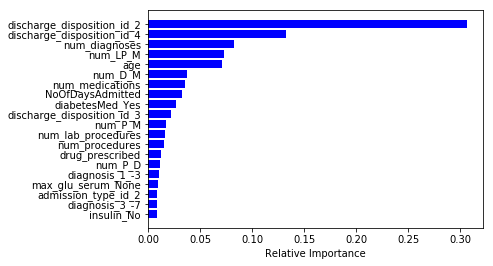

Below are the columns in reverse order of feature importance: 


['discharge_disposition_id_2',
 'discharge_disposition_id_4',
 'num_diagnoses',
 'num_LP_M',
 'age',
 'num_D_M',
 'num_medications',
 'NoOfDaysAdmitted',
 'diabetesMed_Yes',
 'discharge_disposition_id_3',
 'num_P_M',
 'num_lab_procedures',
 'num_procedures',
 'drug_prescribed',
 'num_P_D',
 'diagnosis_1_-3',
 'max_glu_serum_None',
 'admission_type_id_2',
 'diagnosis_3_-7',
 'insulin_No']

In [313]:
#************************ Calculate Feature Importance ************************#
py_preprocessing.class_module_preprocessing.printmd("Feature Importance")
features = pd.DataFrame(X_train).columns
importances = clf_dt.feature_importances_
indices = np.argsort(importances) 
plt.barh(range(len(indices[-20:])), importances[indices[-20:]], color='b', align='center')
plt.yticks(range(len(indices[-20:])), [features[i] for i in indices[-20:]])
plt.xlabel('Relative Importance')
plt.show()


print("Below are the columns in reverse order of feature importance: ")
rev_indices = indices[::-1]
[features[i] for i in rev_indices[0:20]]

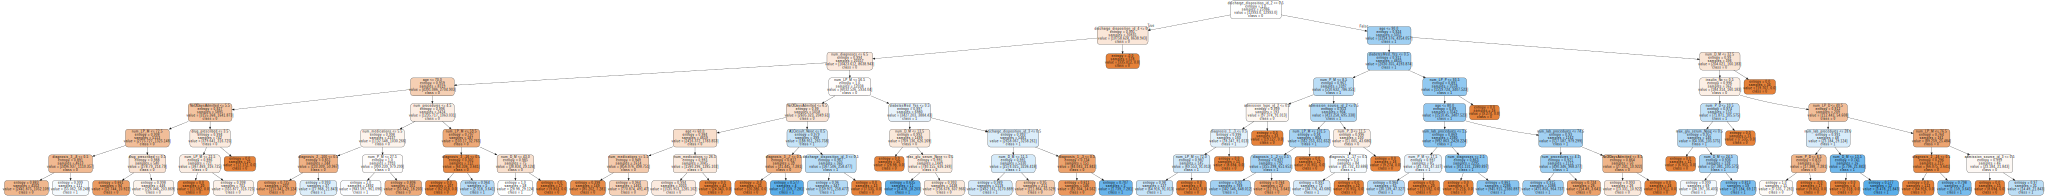

In [316]:
#************************ Display Tree Plot ************************#

py_preprocessing.class_module_preprocessing.fn_dt_plot_tree(clf_dt,df_train_master,'readmitted_Within30days','Tree Plot')

<p><h1><font face="Arial Header" size="5"><span style="color:purple">PART 9: Infer Patterns</span></font></h1></p>

<center><b><span style='color:purple'>PATTERN 1: Readmitted vs race_Caucasian</span></center>

race_Caucasian           False  True 
readmitted_Within30days              
0                         7000  22890
1                         1008   3751 




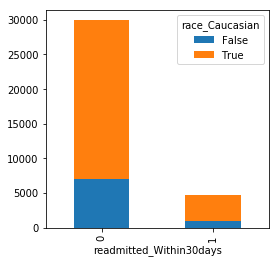

In [303]:
#************************ PATTERN 1 ************************#

clarity_color_table = pd.crosstab(index=df_train_master['readmitted_Within30days'], columns=df_train_master.race_Caucasian == 1)
py_preprocessing.class_module_preprocessing.printmd("PATTERN 1: Readmitted vs race_Caucasian")
print(clarity_color_table, "\n\n")

clarity_color_table.plot(kind="bar", 
                 figsize=(4,4),
                 stacked=True)

### OBSERVATIONS:
# When the race is Caucasian, the probability of getting readmitted within 30 days is high.

<center><b><span style='color:purple'>PATTERN 2: readmitted_Within30days vs num_lab_procedures</span></center>

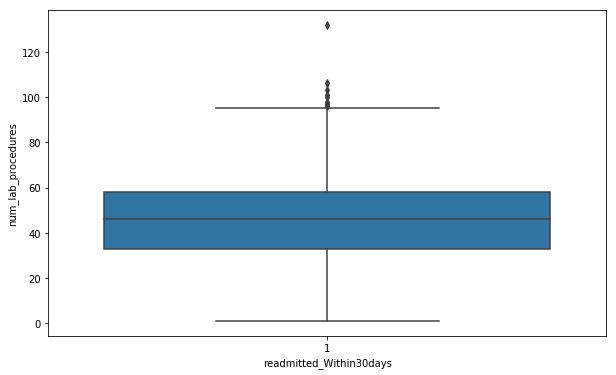

In [317]:
#************************ PATTERN 2 ************************#

py_preprocessing.class_module_preprocessing.printmd("PATTERN 2: readmitted_Within30days vs num_lab_procedures")
plt.figure(figsize=(10,6))
sns.boxplot(x='readmitted_Within30days', y='num_lab_procedures', data=df_train_master[df_train_master.readmitted_Within30days == 1])
plt.show()

### OBSERVATIONS:
# When the number of lab_procedures is between 35-55, the probability of getting readmitted within 30 days is high.

<center><b><span style='color:purple'>PATTERN 3: Readmitted vs max_glu_serum_None</span></center>

max_glu_serum_None          0      1
readmitted_Within30days             
0                        1341  28549
1                         250   4509 




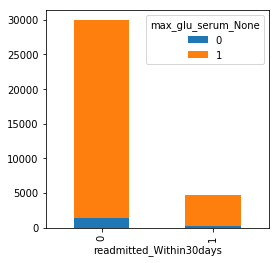

In [322]:
#************************ PATTERN 3 ************************#

clarity_color_table = pd.crosstab(index=df_train_master['readmitted_Within30days'], columns=df_train_master.max_glu_serum_None)
py_preprocessing.class_module_preprocessing.printmd("PATTERN 3: Readmitted vs max_glu_serum_None")
print(clarity_color_table, "\n\n")

clarity_color_table.plot(kind="bar", 
                 figsize=(4,4),
                 stacked=True)

### OBSERVATIONS:
# When the max_glu_serum is None, the probability of getting readmitted within 30 days is high.

<center><b><span style='color:purple'>PATTERN 4: readmitted_Within30days vs num_diagnoses</span></center>

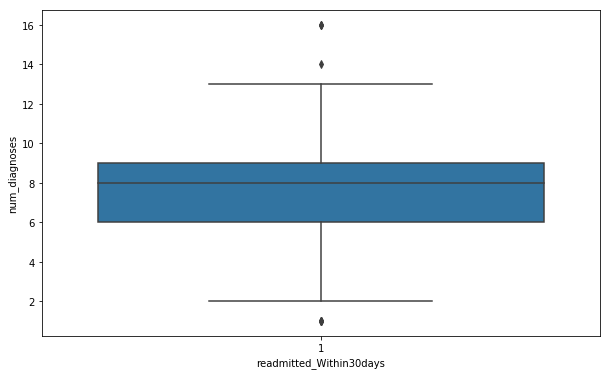

In [319]:
#************************ PATTERN 4 ************************#

py_preprocessing.class_module_preprocessing.printmd("PATTERN 4: readmitted_Within30days vs num_diagnoses")
plt.figure(figsize=(10,6))
sns.boxplot(x='readmitted_Within30days', y='num_diagnoses', data=df_train_master[df_train_master.readmitted_Within30days == 1])
plt.show()

### OBSERVATIONS:
# When the number of diagnoses is between 6-9, the probability of getting readmitted within 30 days is high.

<center><b><span style='color:purple'>PATTERN 5: Readmitted vs repaglinide_No</span></center>

repaglinide_No             0      1
readmitted_Within30days            
0                        333  29557
1                         85   4674 




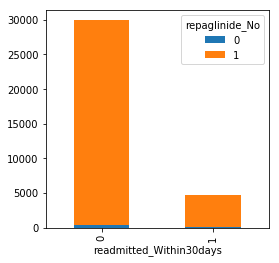

In [323]:
#************************ PATTERN 5 ************************#

clarity_color_table = pd.crosstab(index=df_train_master['readmitted_Within30days'], columns=df_train_master.repaglinide_No)
py_preprocessing.class_module_preprocessing.printmd("PATTERN 5: Readmitted vs repaglinide_No")
print(clarity_color_table, "\n\n")

clarity_color_table.plot(kind="bar", 
                 figsize=(4,4),
                 stacked=True)

### OBSERVATIONS:
# When the drug repaglinide is not prescribed, the probability of getting readmitted within 30 days is high.

<center><b><span style='color:purple'>PATTERN 6: readmitted_Within30days vs drug_prescribed</span></center>

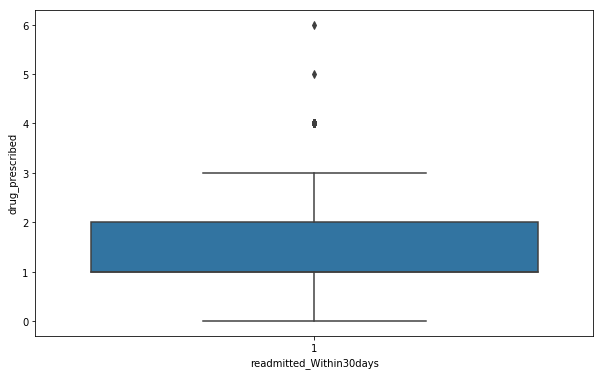

In [320]:
#************************ PATTERN 6 ************************#

py_preprocessing.class_module_preprocessing.printmd("PATTERN 6: readmitted_Within30days vs drug_prescribed")
plt.figure(figsize=(10,6))
sns.boxplot(x='readmitted_Within30days', y='drug_prescribed', data=df_train_master[df_train_master.readmitted_Within30days == 1])
plt.show()

### OBSERVATIONS:
# When the number of drugs prescribed is either 1 or 2, the probability of getting readmitted within 30 days is high.

<center><b><span style='color:purple'>PATTERN 7: Readmitted vs pioglitazone_No</span></center>

pioglitazone_No             0      1
readmitted_Within30days             
0                        2097  27793
1                         356   4403 




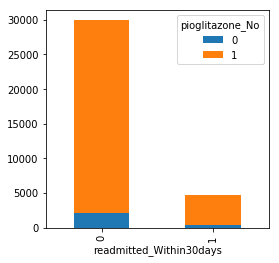

In [324]:
#************************ PATTERN 7 ************************#

clarity_color_table = pd.crosstab(index=df_train_master['readmitted_Within30days'], columns=df_train_master.pioglitazone_No)
py_preprocessing.class_module_preprocessing.printmd("PATTERN 7: Readmitted vs pioglitazone_No")
print(clarity_color_table, "\n\n")

clarity_color_table.plot(kind="bar", 
                 figsize=(4,4),
                 stacked=True)

### OBSERVATIONS:
# When the drug pioglitazone is not prescribed, the probability of getting readmitted within 30 days is high.

<center><b><span style='color:purple'>PATTERN 8: Readmitted vs admission_type_id_2</span></center>

admission_type_id_2          0     1
readmitted_Within30days             
0                        24428  5462
1                         3888   871 




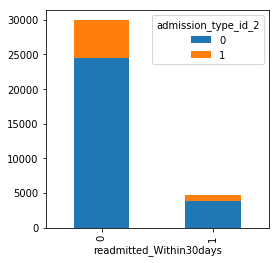

In [325]:
#************************ PATTERN 8 ************************#

clarity_color_table = pd.crosstab(index=df_train_master['readmitted_Within30days'], columns=df_train_master.admission_type_id_2)
py_preprocessing.class_module_preprocessing.printmd("PATTERN 8: Readmitted vs admission_type_id_2")
print(clarity_color_table, "\n\n")

clarity_color_table.plot(kind="bar", 
                 figsize=(4,4),
                 stacked=True)

### OBSERVATIONS:
# When the Admission Type Id is Urgent, the probability of getting readmitted within 30 days is low.

<center><b><span style='color:purple'>PATTERN 9: readmitted_Within30days vs age</span></center>

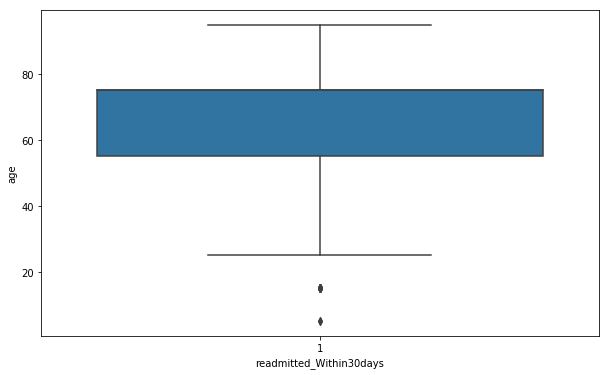

In [326]:
#************************ PATTERN 9 ************************#

py_preprocessing.class_module_preprocessing.printmd("PATTERN 9: readmitted_Within30days vs age")
plt.figure(figsize=(10,6))
sns.boxplot(x='readmitted_Within30days', y='age', data=df_train_master[df_train_master.readmitted_Within30days == 1])
plt.show()

### OBSERVATIONS:
# When the age is between 55-75, the probability of getting readmitted within 30 days is high.

<center><b><span style='color:purple'>PATTERN 10: Readmitted vs glimepiride_No</span></center>

glimepiride_No              0      1
readmitted_Within30days             
0                        1565  28325
1                         255   4504 




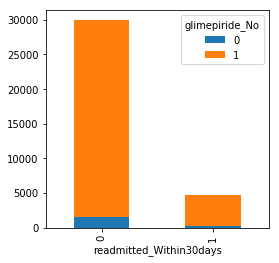

In [327]:
#************************ PATTERN 10 ************************#

clarity_color_table = pd.crosstab(index=df_train_master['readmitted_Within30days'], columns=df_train_master.glimepiride_No)
py_preprocessing.class_module_preprocessing.printmd("PATTERN 10: Readmitted vs glimepiride_No")
print(clarity_color_table, "\n\n")

clarity_color_table.plot(kind="bar", 
                 figsize=(4,4),
                 stacked=True)

### OBSERVATIONS:
# When the drug, glimepiride is not prescribed, the probability of getting readmitted within 30 days is high.

<center><b><span style='color:purple'>PATTERN 11: Readmitted vs diagnosis_1_-9(digestive problems)</span></center>

diagnosis_1_-9               0     1
readmitted_Within30days             
0                        27164  2726
1                         4368   391 




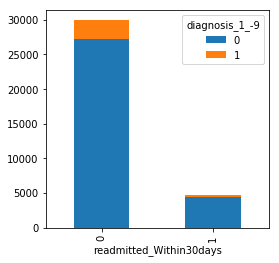

In [366]:
#************************ PATTERN 11 ************************#

clarity_color_table = pd.crosstab(index=df_train_master['readmitted_Within30days'], columns=df_train_master['diagnosis_1_-9'])
py_preprocessing.class_module_preprocessing.printmd("PATTERN 11: Readmitted vs diagnosis_1_-9(digestive problems)")
print(clarity_color_table, "\n\n")

clarity_color_table.plot(kind="bar", 
                 figsize=(4,4),
                 stacked=True)

### OBSERVATIONS:
# When the ICD 9 codes for diganoses is between 520-579 where patient has digestive problems, the probability of getting readmitted within 30 days is low.

<center><b><span style='color:purple'>PATTERN 12: Readmitted vs glipizide_No</span></center>

glipizide_No                0      1
readmitted_Within30days             
0                        3514  26376
1                         655   4104 




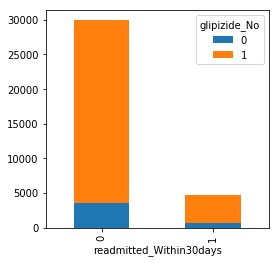

In [329]:
#************************ PATTERN 12 ************************#

clarity_color_table = pd.crosstab(index=df_train_master['readmitted_Within30days'], columns=df_train_master.glipizide_No)
py_preprocessing.class_module_preprocessing.printmd("PATTERN 12: Readmitted vs glipizide_No")
print(clarity_color_table, "\n\n")

clarity_color_table.plot(kind="bar", 
                 figsize=(4,4),
                 stacked=True)

### OBSERVATIONS:
# When the drug glipizide is not prescribed, the probability of getting readmitted within 30 days is high.

<center><b><span style='color:purple'>PATTERN 13: Readmitted vs glyburide_No</span></center>

glyburide_No                0      1
readmitted_Within30days             
0                        3174  26716
1                         554   4205 




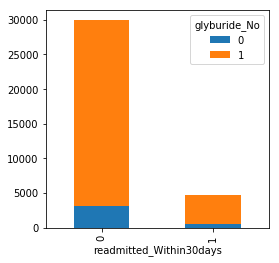

In [367]:
#************************ PATTERN 13 ************************#

clarity_color_table = pd.crosstab(index=df_train_master['readmitted_Within30days'], columns=df_train_master.glyburide_No)
py_preprocessing.class_module_preprocessing.printmd("PATTERN 13: Readmitted vs glyburide_No")
print(clarity_color_table, "\n\n")

clarity_color_table.plot(kind="bar", 
                 figsize=(4,4),
                 stacked=True)

### OBSERVATIONS:
# When the drug glyburide is not prescribed, the probability of getting readmitted within 30 days is high.

<center><b><span style='color:purple'>PATTERN 14: Readmitted vs rosiglitazone_No</span></center>

rosiglitazone_No            0      1
readmitted_Within30days             
0                        1842  28048
1                         305   4454 




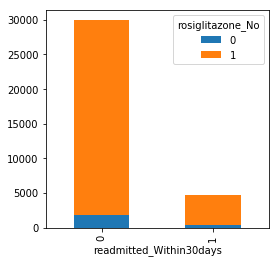

In [344]:
#************************ PATTERN 14 ************************#

clarity_color_table = pd.crosstab(index=df_train_master['readmitted_Within30days'], columns=df_train_master.rosiglitazone_No)
py_preprocessing.class_module_preprocessing.printmd("PATTERN 14: Readmitted vs rosiglitazone_No")
print(clarity_color_table, "\n\n")

clarity_color_table.plot(kind="bar", 
                 figsize=(4,4),
                 stacked=True)

### OBSERVATIONS:
# When the drug rosiglitazone is not prescribed, the probability of getting readmitted within 30 days is high.

<center><b><span style='color:purple'>PATTERN 15: readmitted_Within30days vs num_medications</span></center>

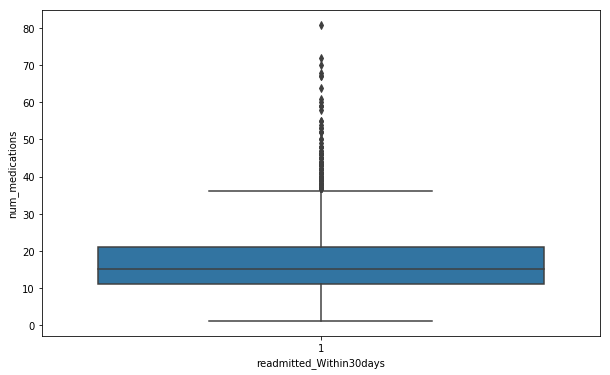

In [345]:
#************************ PATTERN 15 ************************#

py_preprocessing.class_module_preprocessing.printmd("PATTERN 15: readmitted_Within30days vs num_medications")
plt.figure(figsize=(10,6))
sns.boxplot(x='readmitted_Within30days', y='num_medications', data=df_train_master[df_train_master.readmitted_Within30days == 1])
plt.show()

### OBSERVATIONS:
# When the number of medication is between 11-21, the probability of getting readmitted within 30 days is high.

<center><b><span style='color:purple'>PATTERN 16: Readmitted vs metformin_No</span></center>

metformin_No                0      1
readmitted_Within30days             
0                        6437  23453
1                         953   3806 




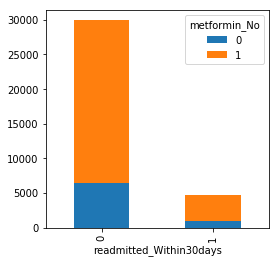

In [346]:
#************************ PATTERN 16 ************************#

clarity_color_table = pd.crosstab(index=df_train_master['readmitted_Within30days'], columns=df_train_master.metformin_No)
py_preprocessing.class_module_preprocessing.printmd("PATTERN 16: Readmitted vs metformin_No")
print(clarity_color_table, "\n\n")

clarity_color_table.plot(kind="bar", 
                 figsize=(4,4),
                 stacked=True)

### OBSERVATIONS:
# When the drug metformin is not prescribed, the probability of getting readmitted within 30 days is high.

<center><b><span style='color:purple'>PATTERN 17: readmitted_Within30days vs num_procedures</span></center>

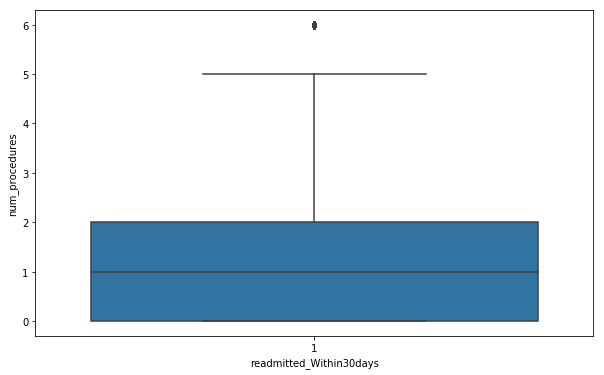

In [347]:
#************************ PATTERN 17 ************************#

py_preprocessing.class_module_preprocessing.printmd("PATTERN 17: readmitted_Within30days vs num_procedures")
plt.figure(figsize=(10,6))
sns.boxplot(x='readmitted_Within30days', y='num_procedures', data=df_train_master[df_train_master.readmitted_Within30days == 1])
plt.show()

### OBSERVATIONS:
# When the number of procedures is less than 2, the probability of getting readmitted within 30 days is high.

<center><b><span style='color:purple'>PATTERN 18: Readmitted vs diabetesMed_Yes</span></center>

diabetesMed_Yes             0      1
readmitted_Within30days             
0                        7890  22000
1                         930   3829 




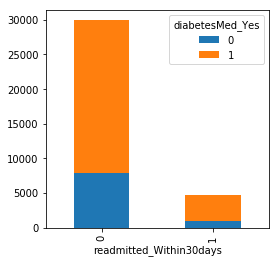

In [348]:
#************************ PATTERN 18 ************************#

clarity_color_table = pd.crosstab(index=df_train_master['readmitted_Within30days'], columns=df_train_master.diabetesMed_Yes)
py_preprocessing.class_module_preprocessing.printmd("PATTERN 18: Readmitted vs diabetesMed_Yes")
print(clarity_color_table, "\n\n")

clarity_color_table.plot(kind="bar", 
                 figsize=(4,4),
                 stacked=True)

### OBSERVATIONS:
# When the diabetes medication is prescribed, the probability of getting readmitted within 30 days is high.

<center><b><span style='color:purple'>PATTERN 19: Readmitted vs discharge_disposition_id_4(Patient expired)</span></center>

discharge_disposition_id_4      0    1
readmitted_Within30days               
0                           29122  768
1                            4759    0 




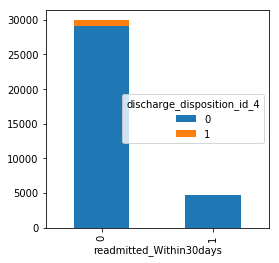

In [368]:
#************************ PATTERN 19 ************************#

clarity_color_table = pd.crosstab(index=df_train_master['readmitted_Within30days'], columns=df_train_master.discharge_disposition_id_4)
py_preprocessing.class_module_preprocessing.printmd("PATTERN 19: Readmitted vs discharge_disposition_id_4(Patient expired)")
print(clarity_color_table, "\n\n")

clarity_color_table.plot(kind="bar", 
                 figsize=(4,4),
                 stacked=True)

### OBSERVATIONS:
# When the patient has expired at home/medical facility/place unknown, the probability of getting readmitted within 30 days is low. Pretty obvious !!!

<center><b><span style='color:purple'>PATTERN 20: Readmitted vs diagnosis_1_-17(patient is either injured or poisoned) for Caucasian Race</span></center>

diagnosis_1_-17              0     1
readmitted_Within30days             
0                        21241  1649
1                         3441   310 




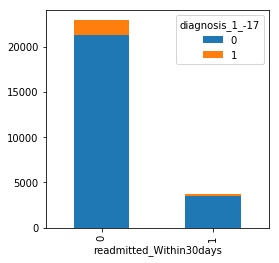

In [369]:
#************************ PATTERN 20 ************************#

clarity_color_table = pd.crosstab(index=df_train_master['readmitted_Within30days'], columns=df_train_master['diagnosis_1_-17'][(df_train_master.race_Caucasian == 1) ])
py_preprocessing.class_module_preprocessing.printmd("PATTERN 20: Readmitted vs diagnosis_1_-17(patient is either injured or poisoned) for Caucasian Race")
print(clarity_color_table, "\n\n")

clarity_color_table.plot(kind="bar", 
                 figsize=(4,4),
                 stacked=True)

### OBSERVATIONS:
# When the race is Caucasian and patient is either injured or poisoned, the probability of getting readmitted within 30 days is low.

<center><b><span style='color:purple'>PATTERN 21: Readmitted vs insulin_Up for admission_type as emergency </span></center>

col_0                    False  True 
readmitted_Within30days              
0                        28059   1831
1                         4424    335 




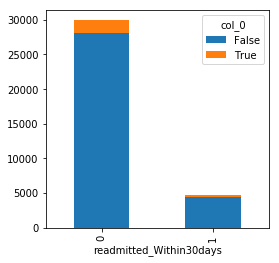

In [370]:
#************************ PATTERN 21 ************************#

clarity_color_table = pd.crosstab(index=df_train_master['readmitted_Within30days'], columns=df_train_master.insulin_Up
                                  [(df_train_master.admission_type_id_2 == 0) & df_train_master.admission_type_id_3 == 0] &
                                 (df_train_master.admission_type_id_4 == 0))
py_preprocessing.class_module_preprocessing.printmd("PATTERN 21: Readmitted vs insulin_Up for admission_type as emergency ")
print(clarity_color_table, "\n\n")

clarity_color_table.plot(kind="bar", 
                 figsize=(4,4),
                 stacked=True)

### OBSERVATIONS:
# When the AdmissionType is emergency and insulin dosage has been increased, the probability of getting readmitted within 30 days is low.

<center><b><span style='color:purple'>PATTERN 22: Patients younger than 45 years and who are suffering from ciculatory system related isues</span></center>

diagnosis_1_-7              0    1
readmitted_Within30days           
0                        2073  124
1                         217   19 




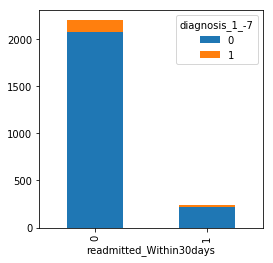

In [372]:
#************************ PATTERN 22 ************************#

clarity_color_table = pd.crosstab(index=df_train_master['readmitted_Within30days'], columns=df_train_master['diagnosis_1_-7'][(df_train_master.age < 45) ])
py_preprocessing.class_module_preprocessing.printmd("PATTERN 22: Patients younger than 45 years and who are suffering from ciculatory system related isues")
print(clarity_color_table, "\n\n")

clarity_color_table.plot(kind="bar", 
                 figsize=(4,4),
                 stacked=True)

### OBSERVATIONS:
# When the patients younger than 45 years and who are suffering from ciculatory system related isues, the probability of getting readmitted within 30 days is low.

<center><b><span style='color:purple'>PATTERN 23: Readmitted vs discharge_disposition_id_2</span></center>

discharge_disposition_id_2      0     1
readmitted_Within30days                
0                           24701  5189
1                            3203  1556 




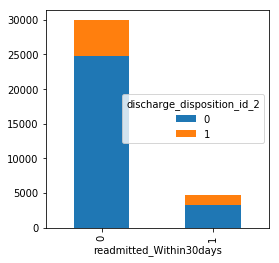

In [373]:
#************************ PATTERN 23 ************************#

clarity_color_table = pd.crosstab(index=df_train_master['readmitted_Within30days'], columns=df_train_master.discharge_disposition_id_2)
py_preprocessing.class_module_preprocessing.printmd("PATTERN 23: Readmitted vs discharge_disposition_id_2")
print(clarity_color_table, "\n\n")

clarity_color_table.plot(kind="bar", 
                 figsize=(4,4),
                 stacked=True)

### OBSERVATIONS:
# When the patient is discharged to other place instead of home, the probability of getting readmitted within 30 days is low.

<p><h1><font face="Arial Header"size="6"><center><span style="color:purple">THE END...THANK YOU !!!</span></font></h1></p>

<img src="Images/Learning.jpg" alt="Italian Trulli1">